## Context from Previous Work: Video Calibration and Ball Detection

### Project Goal
Empirically determine the coefficient of drag for a pickleball by analyzing high-speed video of its free fall in front of a 2'×8' pegboard backdrop.

### Video Characteristics
- File: `freefall.mp4`
- Actual frame count: 70 frames (metadata reported 74)
- Frame rate: ~54.7 fps
- Resolution: 2160×3840 pixels
- Useful frames for analysis: frames 11-63 (ball fully visible)
- Horizontal crop region: x = 800 to 1200 pixels

### Ball Detection Method
**HSV Color Thresholding** proved highly effective:
- Convert frame to HSV color space
- Threshold range: H=[30,80], S=[40,255], V=[40,255]
- Use `cv2.moments()` to find centroid (cx, cy)
- Use `cv2.findContours()` and `cv2.minEnclosingCircle()` for radius
- Function `detect_and_draw_ball(frame, mask)` returns: result image, cx, cy, radius

### Camera Calibration
**Camera tilt angle: 2.14°**
- Measured from ball positions at frames 11 and 63
- Ball fell 3507 pixels vertically, drifted 131 pixels horizontally (left)
- Angle = arctan(131/3507) = 2.14°

**Pegboard angle: 0.34° ± 0.06°** (essentially vertical, negligible)
- Used Hough circle detection on vertical slice of pegboard
- Parameters: `minDist=20, param2=7, minRadius=5, maxRadius=8`
- Detected 60 peg holes across 6 columns
- K-means clustering (n_clusters=6) separated columns
- Linear fit to each column gave consistent angles

### Spatial Calibration
**Pixels per inch: 38.61 pixels/inch**
- Pegboard holes spaced exactly 1 inch apart
- Rotated detected hole positions by camera angle (2.14°)
- Filtered for gaps < 50 pixels (adjacent holes)
- Averaged 15 measurements across all 6 columns

### Coordinate Transformation
Function `rotate_points(points, angle_degrees)` applies rotation matrix to correct for camera tilt, converting observed (x,y) to true vertical coordinates.

### Next Steps
1. Apply ball detection to all frames 11-63
2. Extract and transform (x,y,t) data
3. Convert pixel measurements to physical units (feet/inches)
4. Export time-displacement data to CSV for drag coefficient regression

Before attacking the next steps, I think it would be useful to construct a python package. I expect to re-use many of those functions to create standalone programs.
Possible candidates:
- Ball detection on all frames, exporting just the uncorrected data in CSV format.
- Pegboard backdrop calibration - exporting pegboard angle and pixels per inch
- Camera calibration - perhaps just using the uncorrected data exporting the camera angle.
- Regression to calculate coefficient of drag
- Measure coefficient of restitution
Thoughts on package organization
- cv2 based functions
- separate module (possibly) that uses cv2 functions for ball detection, hole detection
- scikit-learn based function for clustering
- data extraction for measurements
- regression
Refine organization, edit as yet unused pyproject.toml, identify code that we have not created as functions

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great idea to organize this into a reusable package! Let me help you think through the structure before we start building.

Based on your work and future needs, here's a suggested organization:

```
pickleball_physics/
├── __init__.py
├── vision/
│   ├── __init__.py
│   ├── detection.py      # Ball and hole detection (cv2-based)
│   ├── calibration.py    # Camera and pegboard calibration
│   └── transforms.py     # Coordinate transformations, rotation
├── analysis/
│   ├── __init__.py
│   ├── tracking.py       # Extract trajectories from video
│   ├── physics.py        # Drag coefficient, COR calculations
│   └── regression.py     # Fitting models to data
└── utils/
    ├── __init__.py
    └── io.py             # CSV export/import, data handling
```

**Functions you've already created:**
- `detect_and_draw_ball()` → vision/detection.py
- `rotate_points()` → vision/transforms.py
- Hough circle detection for pegs → vision/detection.py
- K-means clustering → vision/calibration.py (or keep sklearn separate?)

**Functions still needed:**
- Video frame iterator/extractor
- Batch ball detection across frames
- Pegboard calibration pipeline (end-to-end)
- Camera angle calculation from ball trajectory
- Physics models for drag/COR
- Regression fitting functions

Does this structure make sense for your use cases? Would you prefer to keep the sklearn clustering more separated, or is it fine within calibration?

Does `transforms` belong in the `vision` (I like that name) section, or do we extract the data and tranform in `analysis`?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! There are two reasonable approaches:

**Option 1: transforms in `vision/`**
- Transforms are part of correcting the raw visual measurements (camera tilt)
- You get calibrated pixel coordinates before leaving the vision layer
- Pro: Clean separation—vision outputs "corrected" coordinates
- Con: Mixes pixel-space operations with corrections

**Option 2: transforms in `analysis/`**
- Vision just extracts raw (x,y) pixel data
- Analysis applies rotations and unit conversions together
- Pro: Vision stays purely detection-focused; all corrections happen in one place
- Con: Analysis needs to know about camera geometry

I'm leaning toward **Option 1** because the rotation correction is fundamentally about fixing the camera's perspective—it's still operating in pixel space. Then `analysis/` would handle the pixels-to-physical-units conversion and physics calculations.

What feels more natural to you for your workflow?

The reason I was thinking about Option 2 
- I don't think we applied transforms to the pixel space
- It would add rectangles on all 4 edges with 2 triangles containing transformed pixels and empty/no-data pixels
- It would be easier to apply 2 transforms, if necessary, to just the data.
- If I thought that we wanted to convert to a "cleaned" video, then option 1 would be better. But we could probably apply transforms to the video regardless.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent points! You're absolutely right—I was conflating image transformation with coordinate transformation.

You're transforming the **data points** (ball positions, hole positions), not the image itself. So:

- `rotate_points()` takes (x,y) coordinates and applies a rotation matrix
- No image warping, no empty pixels
- Easy to chain multiple transformations on the data
- Vision layer outputs raw pixel coordinates; transformations happen in analysis

**Option 2 it is!** So the structure would be:

```
vision/
  detection.py      # Raw (x,y) pixel detection
  calibration.py    # Calculate angles, pixels/inch

analysis/
  transforms.py     # rotate_points(), unit conversions
  tracking.py       # Apply transforms to trajectory data
```

Does that align with what you were thinking? Should we start refining the `pyproject.toml` next, or would you like to map out which specific functions go where first?

While I am considering that, suggestions for a package name?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here are some options to consider:

**Descriptive:**
- `pickleball-physics` (clear, specific)
- `ballistics-cv` (more general, computer vision focus)
- `sports-physics-cv`

**Shorter/catchier:**
- `pbphysics` (pickleball physics)
- `balltrack` (ball tracking)
- `draglab` (focused on drag analysis)

**Playful:**
- `pickle-dynamics`
- `dinkphysics` (pickleball term!)

My favorite is **`pickleball-physics`** because it's clear and searchable, but if you want something more general that could work for other sports balls, **`balltrack`** is nice and concise.

What's your preference? Are you thinking specific to pickleball or more general-purpose?

Names with hyphens won't work in python. Using underscore seems to be frowned upon.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right! Package names with hyphens work for PyPI but cause import issues. The convention is:

**PyPI name:** `pickleball-physics` (hyphens OK)  
**Python import:** `pickleballphysics` (no separators)

Or go with a single word from the start:
- `balltrack`
- `draglab`
- `pbphysics`

Which style do you prefer—compound word like `pickleballphysics`, or something shorter?

ballphysics - not specific to pb, no to drag - maybe I will be able to measure coefficients for restitution and spin. similar argument against track
I like vision and analysis. I suppose they could be separate packages, but I don't know if they merit stand-alone treatment. Finally, should vision
include matplotlib based functions?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

**`ballphysics`** sounds great—flexible for multiple sports and coefficients!

On your questions:

**Separate packages vs. combined:**
For now, keeping `vision` and `analysis` together makes sense. If later you find yourself using vision without analysis (or vice versa), you can always split them. Start simple.

**matplotlib in vision?**
I'd say **no**—keep matplotlib separate. Here's my thinking:
- `vision/` focuses on detection and calibration (cv2)
- `analysis/` does physics calculations (numpy, scipy)
- Add a `visualization/` module for plotting functions

That way, vision and analysis stay focused on their core tasks, and someone could use your detection/analysis without matplotlib as a dependency.

Structure:
```
ballphysics/
├── vision/
├── analysis/
└── visualization/  # matplotlib-based plotting
```

Does that separation work for you?

Yes, 
`import ballphysics.vision as bpcv` or `bpv`
`import ballphysics.analysis as bpa`
`import ballphysics.visualization as bpviz`


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Those import aliases are clean and intuitive.

So we have:
```
ballphysics/
├── __init__.py
├── vision/
│   ├── __init__.py
│   ├── detection.py
│   ├── calibration.py
├── analysis/
│   ├── __init__.py
│   ├── transforms.py
│   ├── tracking.py
│   ├── physics.py
│   ├── regression.py
└── visualization/
    ├── __init__.py
    └── plotting.py  (or split further?)
```

Ready to work on the `pyproject.toml`? We'll need to specify dependencies like `opencv-python`, `numpy`, `scipy`, `scikit-learn`, `matplotlib`, etc.

Yes, I think the physics part can come from https://github.com/fm75/Pickleball-Physics, another project where we already did significant work.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! So you can pull the physics models from that existing project. That will save a lot of work.

For the `pyproject.toml`, we'll need to define:
- Package metadata (name, version, description, author)
- Dependencies (opencv-python, numpy, scipy, scikit-learn, matplotlib)
- Optional dependencies (for dev/testing)
- Python version requirement

Do you have an existing `pyproject.toml` file that needs editing, or should we create one from scratch? And what Python version are you targeting (3.10+, 3.12+)?

```
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[project]
name = "Add Name Here"
version = "0.1.0"
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good start! Let's fill in the essential fields. Here's what we need to add:

```toml
[project]
name = "ballphysics"
version = "0.1.0"
description = "Computer vision and physics analysis for ball sports trajectories"
requires-python = ">=3.10"
dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
]
```

A few questions:
1. What Python version do you want to require? (I suggested 3.10+)
2. Do you want to add author info and a license field?
3. Should we add optional dependencies for development (like `pytest`, `jupyter`)?

The latest release of ubuntu comes with 3.12 which has just turned 2 years old. I don't intend, at this point, to ever put it on pypi. Even if
I did, I would not want to work on issues from prior to 3.12. That is available on `mybinder.org`, and `tljh`. I have 3.14 installed on my Macs.
Author ok, License MIT, I guess. That is what I put on Pickleball-Physics.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So we'll set:
- `requires-python = ">=3.12"`
- MIT license
- Add your author info

For the author field, what would you like to use? Format is typically:
```toml
authors = [
    {name = "Your Name", email = "your.email@example.com"}
]
```

And should we add optional dev dependencies like `pytest` or `jupyter` in a separate group?

Yes. pytest and jupyterlab. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Here's what the `pyproject.toml` should look like with those additions:

```toml
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[project]
name = "ballphysics"
version = "0.1.0"
description = "Computer vision and physics analysis for ball sports trajectories"
requires-python = ">=3.12"
license = {text = "MIT"}
authors = [
    {name = "Your Name", email = "your.email@example.com"}
]
dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
]

[project.optional-dependencies]
dev = [
    "pytest",
    "jupyterlab",
]
```

Just replace the author name and email with your actual info. Does this look good, or would you like to add anything else (like a readme field, repository URL, or other metadata)?

This work lives in https://github.com/fm75/pickleball-data-analysis - It has a relatively empty README.md ATM. The raw data won't live in github. Not sure what metadata we 
might want.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good point about keeping raw data out of git. We can add the repository URL to the `pyproject.toml`:

```toml
[project.urls]
Repository = "https://github.com/fm75/pickleball-data-analysis"
```

For the README, you could add:
- Brief description of what the package does
- Installation instructions (`pip install -e .` for local dev)
- Basic usage example with the import aliases you chose
- Note about where data should be stored (local directory structure)

Do you want to add the repository URL to the toml now? And would you like suggestions for what to put in the README, or do you prefer to handle that separately later?

repo yes. README when we are done with the follow-on tasks. Not to be done, yet.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So the complete `pyproject.toml` is:

```toml
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[project]
name = "ballphysics"
version = "0.1.0"
description = "Computer vision and physics analysis for ball sports trajectories"
requires-python = ">=3.12"
license = {text = "MIT"}
authors = [
    {name = "Your Name", email = "your.email@example.com"}
]
dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
]

[project.optional-dependencies]
dev = [
    "pytest",
    "jupyterlab",
]

[project.urls]
Repository = "https://github.com/fm75/pickleball-data-analysis"
```

Just update your author info. Ready to start organizing the actual code into the package structure?

.toml updated.
A script of `touch` commands would be a nice convenience.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's a script to create the package structure:

```bash
mkdir -p ballphysics/vision
mkdir -p ballphysics/analysis
mkdir -p ballphysics/visualization

touch ballphysics/__init__.py
touch ballphysics/vision/__init__.py
touch ballphysics/vision/detection.py
touch ballphysics/vision/calibration.py
touch ballphysics/analysis/__init__.py
touch ballphysics/analysis/transforms.py
touch ballphysics/analysis/tracking.py
touch ballphysics/analysis/physics.py
touch ballphysics/analysis/regression.py
touch ballphysics/visualization/__init__.py
touch ballphysics/visualization/plotting.py
```

Would you like to run this to create the structure, or would you prefer to adjust anything first?

Except for `touch ballphysics/analysis/physics.py`, yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the updated script:

```bash
mkdir -p ballphysics/vision
mkdir -p ballphysics/analysis
mkdir -p ballphysics/visualization

touch ballphysics/__init__.py
touch ballphysics/vision/__init__.py
touch ballphysics/vision/detection.py
touch ballphysics/vision/calibration.py
touch ballphysics/analysis/__init__.py
touch ballphysics/analysis/transforms.py
touch ballphysics/analysis/tracking.py
touch ballphysics/analysis/regression.py
touch ballphysics/visualization/__init__.py
touch ballphysics/visualization/plotting.py
```

Ready to start populating these modules with your existing functions?

oops. I meant for them to live in `src/`. I will correct the locations with some `mv` commands.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah, good catch! Using `src/` is a best practice for package layout. 

Once you've moved everything with `mv`, your structure will be:

```
src/ballphysics/
├── __init__.py
├── vision/
├── analysis/
└── visualization/
```

You'll also need to update `pyproject.toml` to tell setuptools about the `src/` layout. Add this section:

```toml
[tool.setuptools.packages.find]
where = ["src"]
```

Let me know once you've moved the files and I can help with the next step!

## Replacement for `tree`

yeah, those also.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the updated alias to exclude `.git`, `__pycache__`, and `.venv`:

```bash
alias tree='find . -path ./.git -prune -o -path "*/__pycache__" -prune -o -path ./.venv -prune -o -type d -print | sed -e "s/[^-][^\/]*\//  |/g" -e "s/|\([^ ]\)/|-\1/"'
```

Each `-path ... -prune -o` pair skips that directory pattern. The `*/__pycache__` will match `__pycache__` at any level.

Want to test it out?

Replacement worked. toml updated
```
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[tool.setuptools.packages.find]
where = ["src"]

[project]
...
```
Ready to populate modules.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's start populating the modules with your existing functions.

Which module would you like to tackle first? I'd suggest starting with one of these:

1. **`vision/detection.py`** - Your `detect_and_draw_ball()` function and peg hole detection
2. **`analysis/transforms.py`** - Your `rotate_points()` function (simplest to start)
3. **`vision/calibration.py`** - Camera angle and pegboard calibration logic

Which one appeals to you, or would you prefer a different starting point?

1

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start with `vision/detection.py`.

From your context, you have:
- `detect_and_draw_ball(frame, mask)` - returns result image, cx, cy, radius
- Hough circle detection for peg holes with specific parameters

For the module structure, should we:
1. Keep `detect_and_draw_ball()` as-is (returns image + coordinates)
2. Split it into separate functions: `detect_ball()` (just returns cx, cy, radius) and `draw_ball()` (visualization)?

The split approach would be more modular - detection in `vision/`, drawing in `visualization/`. What do you prefer?

Split as suggested

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good choice! So for `vision/detection.py` we'll have:

**Functions to create:**
- `detect_ball(frame)` - returns cx, cy, radius (or None values if not found)
- `detect_peg_holes(frame, ...)` - returns list of hole coordinates using Hough circles

And move the drawing to `visualization/plotting.py`:
- `draw_ball(frame, cx, cy, radius)` - returns annotated image

For `detect_ball()`, should it:
1. Take the HSV threshold values as parameters (flexible), or
2. Use the working values [30,80], [40,255], [40,255] as defaults?

What's your preference?

Defaults. Also documentation on how those values were derived. I might very well do some greener balls. Or even other colors.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! So `detect_ball()` will have HSV threshold parameters with defaults, and we'll document how those values were determined for the yellow pickleball.

For the documentation, should we:
1. Put detailed comments in the function docstring explaining the HSV range selection process?
2. Create a separate markdown doc (like `docs/hsv_calibration.md`) with examples?
3. Both?

Also, do you want to write the `detect_ball()` function yourself, or would you like me to draft it for you to review/modify?

3. concise details - possibly including reference to 2
draft for review.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! I'll draft `detect_ball()` with:
- Concise docstring explaining HSV selection
- Reference to a future calibration doc
- Default HSV values for yellow pickleball

Here's the draft for `vision/detection.py`:

```python
import cv2
import numpy as np

def detect_ball(frame, h_range=(30, 80), s_range=(40, 255), v_range=(40, 255)):
    """
    Detect ball position and size using HSV color thresholding.
    
    Args:
        frame: BGR image from cv2
        h_range: Hue range (default for yellow pickleball)
        s_range: Saturation range
        v_range: Value range
    
    Returns:
        tuple: (cx, cy, radius) or (None, None, None) if not detected
    
    Note:
        Default HSV ranges were empirically determined for yellow pickleballs
        under indoor lighting. For other ball colors or lighting conditions,
        see docs/hsv_calibration.md for threshold selection guidance.
    """
    # Convert to HSV and create mask
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, 
                       np.array([h_range[0], s_range[0], v_range[0]]),
                       np.array([h_range[1], s_range[1], v_range[1]]))
    
    # Find centroid using moments
    moments = cv2.moments(mask)
    if moments['m00'] == 0:
        return None, None, None
    
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    
    # Find radius using contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cx, cy, None
    
    largest_contour = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest_contour)
    
    return cx, cy, radius
```

Does this look good? Any changes you'd like before we move on to `detect_peg_holes()`?

Would it be better with type hints, or would that just be too messy?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Type hints would make it clearer! For this function they're pretty straightforward:

```python
def detect_ball(frame: np.ndarray, 
                h_range: tuple[int, int] = (30, 80), 
                s_range: tuple[int, int] = (40, 255), 
                v_range: tuple[int, int] = (40, 255)) -> tuple[int | None, int | None, float | None]:
```

The return type is a bit verbose with the `| None` unions. We could also use:

```python
from typing import Optional

-> tuple[Optional[int], Optional[int], Optional[float]]:
```

Which style do you prefer? The modern `|` syntax (3.10+) or `Optional`?

What is the alternative return type?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

There are a few alternatives for the return type:

1. **Named tuple** - more readable access:
```python
from typing import NamedTuple

class BallDetection(NamedTuple):
    cx: int | None
    cy: int | None
    radius: float | None

-> BallDetection:
```
Then use: `result.cx, result.cy, result.radius`

2. **Dataclass** - similar but more flexible:
```python
from dataclasses import dataclass

@dataclass
class BallDetection:
    cx: int | None
    cy: int | None
    radius: float | None
```

3. **Optional tuple** - simpler but less precise:
```python
-> tuple[int, int, float] | None:
```
Returns the whole tuple as None if not detected (changes your logic though)

Which approach appeals to you?

I like the Dataclass version.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great choice! Dataclasses are clean and flexible. Here's the updated version with the dataclass:

```python
import cv2
import numpy as np
from dataclasses import dataclass

@dataclass
class BallDetection:
    cx: int | None
    cy: int | None
    radius: float | None

def detect_ball(frame: np.ndarray, 
                h_range: tuple[int, int] = (30, 80), 
                s_range: tuple[int, int] = (40, 255), 
                v_range: tuple[int, int] = (40, 255)) -> BallDetection:
    """
    Detect ball position and size using HSV color thresholding.
    
    Args:
        frame: BGR image from cv2
        h_range: Hue range (default for yellow pickleball)
        s_range: Saturation range
        v_range: Value range
    
    Returns:
        BallDetection with cx, cy, radius (None values if not detected)
    
    Note:
        Default HSV ranges were empirically determined for yellow pickleballs
        under indoor lighting. For other ball colors or lighting conditions,
        see docs/hsv_calibration.md for threshold selection guidance.
    """
    # Convert to HSV and create mask
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, 
                       np.array([h_range[0], s_range[0], v_range[0]]),
                       np.array([h_range[1], s_range[1], v_range[1]]))
    
    # Find centroid using moments
    moments = cv2.moments(mask)
    if moments['m00'] == 0:
        return BallDetection(None, None, None)
    
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    
    # Find radius using contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return BallDetection(cx, cy, None)
    
    largest_contour = max(contours, key=cv2.contourArea)
    (_, _), radius = cv2.minEnclosingCircle(largest_contour)
    
    return BallDetection(cx, cy, radius)
```

Ready to move on to `detect_peg_holes()` next?

In [ ]:
That looks good. Yes.

SyntaxError: invalid syntax (2423846522.py, line 1)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

For `detect_peg_holes()`, from your context you used:
- Hough circle detection on a vertical slice of the pegboard
- Parameters: `minDist=20, param2=7, minRadius=5, maxRadius=8`
- Detected circles across multiple columns

Should this function:
1. Take a full frame and extract a vertical slice internally?
2. Take a pre-cropped region as input?
3. Accept slice coordinates as parameters?

Also, should it return raw circle coordinates, or organize them by column right away?

Interesting questions. How about functions for vertical, horizontal, and both slicing. I know that **could** just be one function (both)
but each of vertical and horizontal were very useful. Regardless of the answers to 1,3 we would be performing them somewhere.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good point! Having dedicated slicing functions makes the code clearer and more reusable.

So we'd have utility functions like:
```python
def extract_vertical_slice(frame, x_start, x_end)
def extract_horizontal_slice(frame, y_start, y_end)
def extract_region(frame, x_start, x_end, y_start, y_end)
```

Should these go in:
1. `vision/detection.py` (alongside the detection functions)?
2. A new `vision/utils.py` module?
3. Somewhere else?

And for `detect_peg_holes()`, do you want it to take slice coordinates as parameters, or accept either a full frame with coordinates OR a pre-sliced region?

I had not thought about utils. If we put it there, it can be used for non-detection operations.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent point! `vision/utils.py` keeps these slicing functions available for any vision-related task.

So we'll add to your structure:
```
src/ballphysics/vision/utils.py
```

Should I draft the three slicing functions (`extract_vertical_slice`, `extract_horizontal_slice`, `extract_region`) for you, or would you like to write them yourself?

And we still need to decide: should `detect_peg_holes()` take slice coordinates as parameters, or work with pre-sliced input?

how about writing the slicing convenience functions? I will put them in. Then repeat the questions on ball and peghole detection.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here are the slicing functions for `vision/utils.py`:

```python
import numpy as np

def extract_vertical_slice(frame: np.ndarray, x_start: int, x_end: int) -> np.ndarray:
    """Extract a vertical slice from frame between x_start and x_end."""
    return frame[:, x_start:x_end]

def extract_horizontal_slice(frame: np.ndarray, y_start: int, y_end: int) -> np.ndarray:
    """Extract a horizontal slice from frame between y_start and y_end."""
    return frame[y_start:y_end, :]

def extract_region(frame: np.ndarray, x_start: int, x_end: int, y_start: int, y_end: int) -> np.ndarray:
    """Extract a rectangular region from frame."""
    return frame[y_start:y_end, x_start:x_end]
```

Now for `detect_peg_holes()`:
1. Should it take slice coordinates as parameters and extract the slice internally, or accept a pre-sliced frame?
2. Should it return just the raw circle coordinates, or organize them (e.g., by column)?

What's your preference?

I think 
- Some function should return raw coordinates.
- Some function should handle clustering (an input for maximum clusters was important
- Some function should work on a pre-sliced frame.
- Do we have a hope that detect_peg_holes can select a suitable slice? We need enough holes and enough clusters for the results to be usable for calibration.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Those are great questions! Let me think through the detection challenge:

For `detect_peg_holes()` to auto-select a slice, it would need to:
- Try different slice locations/widths
- Detect circles in each
- Check if it found "enough" holes across "enough" columns
- That's getting complex and might be fragile

**Alternative approach:**
1. `detect_circles(frame, minDist=20, param2=7, minRadius=5, maxRadius=8)` - returns raw (x, y, radius) on pre-sliced frame
2. `cluster_holes(circles, n_clusters)` - takes raw circles, returns clustered by column
3. Higher-level function (maybe in `calibration.py`?) orchestrates: slice → detect → cluster → validate

This keeps detection simple and reusable. The calibration module can handle the "did we get good data?" logic.

Does that separation make sense to you?

detect_holes, cluster_holes. Yes, I think calibration, might be best for the slicing decision. We use the calibration piece directly
and normally don't use the detect/cluster stuff. If we go that route, calibration then needs to work - guidance on clustering, params, radii. ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! So the flow would be:

**In `vision/detection.py`:**
- `detect_holes(frame, minDist, param2, minRadius, maxRadius)` - raw Hough circles

**In `vision/calibration.py`:**
- `cluster_holes(circles, n_clusters)` - K-means clustering
- `calibrate_pegboard(frame, slice_coords, n_clusters, hough_params)` - orchestrates everything, validates results, returns pixels/inch and angle

The high-level `calibrate_pegboard()` would:
1. Extract slice using utils
2. Call `detect_holes()` with Hough params
3. Call `cluster_holes()` 
4. Validate (enough holes? reasonable spacing?)
5. Calculate pixels/inch and angle

Does this division of responsibilities work for you? Should we draft `detect_holes()` next, or jump to the calibration orchestration?

Pixels/inch worked because it was vertical enough not to have to correct for its angle. I think we set some sort of tolerance
on the angle for acceptance. My plumb bob idea and shimming should just be an easy part of the experimental setup.
How about default slice parameters for calibration. It reports results of pixels/inch, hole count, hole radius, angle, etc.
User decides whether to accept. (Maybe later, something handles the slicing until acceptance is achieved or it gives up logging everything
that did not work.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! So for `calibrate_pegboard()`:

**Inputs:**
- `frame`
- Optional slice parameters (with sensible defaults based on your 800-1200 horizontal crop?)
- Optional Hough parameters (defaults from your working values)
- Optional `n_clusters` (default 6?)
- Optional angle tolerance for acceptance

**Outputs/Reports:**
- pixels_per_inch
- pegboard_angle
- hole_count
- average_hole_radius
- cluster distribution
- Pass/fail based on angle tolerance

The function returns all these metrics so the user can decide whether to accept. Later, a wrapper could iterate different slices automatically.

Should we draft `detect_holes()` first (simple), then build up to `calibrate_pegboard()`? Or start with the high-level calibration function structure?

At some point, we will have average ball radius and average hole radius. They will simply need to make sense. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good point! Those radius measurements are useful sanity checks:

**Expected values:**
- Pickleball diameter: ~2.9 inches → radius ~1.45 inches
- Pegboard holes: typically 1/4 inch diameter → radius ~0.125 inches

So once we have pixels/inch calibration, we can validate:
- Ball radius in pixels / pixels_per_inch ≈ 1.45 inches?
- Hole radius in pixels / pixels_per_inch ≈ 0.125 inches?

Should `calibrate_pegboard()` include this validation and report whether the physical dimensions make sense? Or keep that as a separate validation step the user runs?

Exactly what I was thinking. But hit shift-enter instead of enter. I was not going to list the sizes, but you did. I can look up the regulations
on the ball later, but the ball might calculate slightly higher than its actual diameter because 1) it will be moving, 2) it will be 1-3 inches
from the pegboard, with the camera 20+ feet away.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent observations! The motion blur and parallax effects are real considerations:

**Motion blur:** Moving ball → slightly larger detected radius
**Parallax:** Ball is ~2 inches in front of pegboard, camera ~20 feet away → small but measurable offset

For validation, we could use ranges instead of exact values:
- Ball radius: 1.3-1.6 inches (allowing for blur/parallax)
- Hole radius: 0.10-0.15 inches (manufacturing tolerance)

Should the validation:
1. Just report the calculated physical sizes and let you judge?
2. Include warning thresholds (soft limits)?
3. Include hard failure limits (reject calibration)?

What level of automation do you want here?

Just supply a range for now. I can tune that later. Warning and hard makes sense.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So `calibrate_pegboard()` will report calculated physical dimensions and compare against ranges:

**Validation levels:**
- **Warning:** Dimensions outside expected range but plausible (log warning, continue)
- **Hard fail:** Dimensions completely unreasonable (return error status)

We can make the ranges configurable parameters with sensible defaults.

Ready to draft `detect_holes()` now? It should be straightforward - just wrap the Hough circle detection with your working parameters as defaults.

Please do. Hough documentation is in the function and eventually the doc, but mention of it should be here. Also a note on clustering.
I don't think 6 was critical, because with 4, it had a good fit to a good set of two lines.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the draft for `detect_holes()` in `vision/detection.py`:

```python
def detect_holes(frame: np.ndarray, 
                 min_dist: int = 20,
                 param2: int = 7,
                 min_radius: int = 5,
                 max_radius: int = 8) -> np.ndarray | None:
    """
    Detect circular holes (e.g., pegboard) using Hough Circle Transform.
    
    Args:
        frame: Grayscale or BGR image
        min_dist: Minimum distance between detected circle centers
        param2: Accumulator threshold for circle detection (lower = more circles)
        min_radius: Minimum circle radius in pixels
        max_radius: Maximum circle radius in pixels
    
    Returns:
        Array of shape (N, 3) with (x, y, radius) for each detected circle,
        or None if no circles detected
    
    Note:
        Uses cv2.HoughCircles with HOUGH_GRADIENT method. For pegboard calibration,
        apply to a vertical or horizontal slice for best results. Detected holes
        can be clustered by column/row for spatial calibration (see cluster_holes).
        Default parameters tuned for 1/4" pegboard holes at typical camera distances.
        See docs/hough_calibration.md for parameter tuning guidance.
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1,
                               minDist=min_dist, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    
    if circles is None:
        return None
    
    return circles[0]  # Returns (N, 3) array
```

Does this look good? Ready for `cluster_holes()` next?

Added. If cluster_holes is ready, I will put it in, too. After that I need to get ready to *go play*.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's `cluster_holes()` for `vision/calibration.py`:

```python
import numpy as np
from sklearn.cluster import KMeans

def cluster_holes(circles: np.ndarray, n_clusters: int = 6) -> tuple[np.ndarray, np.ndarray]:
    """
    Cluster detected holes by column (or row) using K-means.
    
    Args:
        circles: Array of shape (N, 3) with (x, y, radius) from detect_holes()
        n_clusters: Number of columns/rows to cluster into
    
    Returns:
        tuple of (circles, labels) where labels indicate cluster assignment
    
    Note:
        For vertical pegboard columns, clusters by x-coordinate. For horizontal
        rows, transpose or cluster by y-coordinate. The number of clusters doesn't
        need to match the exact number of columns - even with fewer clusters,
        linear fits to hole positions can provide good calibration results.
    """
    positions = circles[:, :2]  # Extract (x, y) coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(positions)
    
    return circles, labels
```

Enjoy your game! 🏓

circles was input

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right! The return should just be `labels` since `circles` was the input:

```python
def cluster_holes(circles: np.ndarray, n_clusters: int = 6) -> np.ndarray:
    """
    Cluster detected holes by column (or row) using K-means.
    
    Args:
        circles: Array of shape (N, 3) with (x, y, radius) from detect_holes()
        n_clusters: Number of columns/rows to cluster into
    
    Returns:
        Array of cluster labels for each circle
    
    Note:
        For vertical pegboard columns, clusters by x-coordinate. For horizontal
        rows, transpose or cluster by y-coordinate. The number of clusters doesn't
        need to match the exact number of columns - even with fewer clusters,
        linear fits to hole positions can provide good calibration results.
    """
    positions = circles[:, :2]  # Extract (x, y) coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(positions)
    
    return labels
```

Better?

back

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Welcome back! Hope you had a good game! 

We've got `detect_ball()`, `detect_holes()`, and `cluster_holes()` done. 

What would you like to work on next? We still have:
- `calibrate_pegboard()` (the orchestration function)
- `analysis/transforms.py` (your `rotate_points()` function)
- `visualization/plotting.py` (drawing functions)
- Or something else?

That order looks fine

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's tackle `calibrate_pegboard()` in `vision/calibration.py`.

This function needs to orchestrate the whole calibration process. Before I draft it, let me clarify a few things:

From your context, the calibration process:
1. Extracts a slice
2. Detects holes
3. Clusters them
4. Rotates hole positions by camera angle
5. Calculates spacing between adjacent holes
6. Averages to get pixels/inch
7. Fits lines to each column to get pegboard angle

Should `calibrate_pegboard()`:
- Take the camera angle as input (since you calculate that separately from ball trajectory)?
- Or should it calculate pegboard angle independently without camera angle correction?

What's the workflow you envision?

I feel like pegboard gets set up with a level or a plumb bob. So it should be less than 1 degree off. I used a Lumix S5 IIx camera. It
has some sort of levelness display. I don't know if I used it. I also don't know whether higher end tripods might help. I do think that I 
might be able to work out getting it level by coupling it to a macbook for set up - but capturing videos to the camera directly.
It is reasonable to expect some levelness issues with the camera, but I would want it to be less than 3 degrees.

Including a camera angle input make sense. It can default to zero. With the option, we could even compare the outputs. 

Ball detection - report in frame units.
Hole detection, report in frame units.
Analysis of pegboard
- Cluster holes and regress for angle
- Tranform holes in frame to holes vertical
- Calculate pixel density
Analysis of camera is like above, but no clustering needed.
Analysis of tractory 
- Transform ball data to physical it can use both camera and pegboard rotations.
Coefficient calculation
- Uses physical ball data (incuding time via frame rate) to calculate.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent breakdown! That clarifies the workflow nicely.

So `calibrate_pegboard()` should:
1. Detect and cluster holes (in frame coordinates)
2. Fit lines to clusters → pegboard angle
3. Optionally accept camera_angle (default=0)
4. Apply rotation(s) to get vertical coordinates
5. Calculate pixels/inch from vertical spacing
6. Report: pixels/inch, pegboard_angle, hole_count, avg_radius, validation status

**Key question:** When calculating pixels/inch, do you:
- Rotate holes by pegboard angle only (to make pegboard vertical)?
- Or rotate by (camera_angle + pegboard_angle) to get true vertical?

My guess: Just pegboard angle, since you're measuring the pegboard's own spacing. The camera angle gets applied separately when transforming ball trajectory. Is that right?

Yes. The hole spacing is physical to the board - assuming the pixels are "square". Won't the distance from one hole to the next be the same after transforming any angle. 
The spacing is one inch in x and one inch in Y. Camera angle is needed to correct the ball flight to vertical.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're absolutely right! The hole spacing is invariant under rotation - rotating doesn't change the distance between holes. So we don't need to rotate the holes at all to calculate pixels/inch.

The workflow is:
1. Detect and cluster holes (frame coordinates)
2. Fit lines to clusters → pegboard angle (for validation/reporting)
3. Measure spacing between adjacent holes directly in frame coordinates
4. Average those spacings → pixels/inch

The camera angle is only needed later for transforming ball trajectory to true vertical.

Should `calibrate_pegboard()` still calculate and report the pegboard angle (as a quality check that it's nearly vertical), even though we don't use it for the pixels/inch calculation?

Yes. The hole spacing is physical to the board - assuming the pixels are "square". Won't the distance from one hole to the next be the same after transforming any angle. 
The spacing is one inch in x and one inch in Y. Camera angle is needed to correct the ball flight to vertical.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're absolutely right! The Euclidean distance between holes is invariant under rotation. So we can calculate pixels/inch directly from frame coordinates without any rotation.

The workflow is:
1. Detect and cluster holes (frame coordinates)
2. Fit lines to clusters → pegboard angle (for validation - should be < 1°)
3. Calculate distances between adjacent holes in each cluster
4. Filter for ~1 inch spacings (< some threshold)
5. Average → pixels/inch

Should `calibrate_pegboard()` report the pegboard angle as a quality metric (with warning if > 1°), even though we don't use it for the calculation?

I think I just convince my self that the board measurement does NOT need camera angle corrections.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! The pegboard measurement is independent of camera angle because:
- You're measuring physical spacing on the board itself
- Distance between holes doesn't change with rotation
- The board's own angle doesn't matter for the 1-inch spacing

Camera angle correction is only for the ball trajectory - to transform its observed motion into true vertical fall.

Ready to draft `calibrate_pegboard()` with this understanding?

Yes. I would like to see that built with functions for each of the steps.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good approach! Let's break `calibrate_pegboard()` into helper functions. Here's the structure:

**Helper functions needed:**
1. `_fit_lines_to_clusters(circles, labels)` → returns angles for each cluster
2. `_calculate_hole_spacings(circles, labels)` → returns array of distances between adjacent holes
3. `_validate_pegboard_angle(angles, tolerance)` → checks if board is level enough
4. `_validate_physical_dimensions(avg_radius, pixels_per_inch, hole_range)` → checks hole size makes sense

Then `calibrate_pegboard()` orchestrates:
- Extract slice → detect → cluster
- Call helpers to get angle, pixels/inch
- Validate and report results

Should I draft these one at a time, or would you like to see the full structure with all helpers at once?

Write it with the unimplemented components - for a sanity - design check?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the structure for `calibrate_pegboard()` with unimplemented helpers:

```python
from dataclasses import dataclass
import numpy as np
from .detection import detect_holes
from ..utils import extract_vertical_slice

@dataclass
class PegboardCalibration:
    pixels_per_inch: float
    pegboard_angle: float
    hole_count: int
    avg_hole_radius: float
    status: str  # 'pass', 'warning', 'fail'
    messages: list[str]

def calibrate_pegboard(frame: np.ndarray,
                       slice_x_start: int = 800,
                       slice_x_end: int = 1200,
                       n_clusters: int = 6,
                       angle_tolerance: float = 1.0,
                       hole_radius_range: tuple[float, float] = (0.10, 0.15),
                       **hough_params) -> PegboardCalibration:
    """
    Calibrate spatial measurements using pegboard backdrop.
    
    Returns calibration metrics and validation status.
    """
    # Extract slice and detect holes
    slice_frame = extract_vertical_slice(frame, slice_x_start, slice_x_end)
    circles = detect_holes(slice_frame, **hough_params)
    
    if circles is None:
        return PegboardCalibration(0, 0, 0, 0, 'fail', ['No holes detected'])
    
    # Cluster holes by column
    labels = cluster_holes(circles, n_clusters)
    
    # Calculate metrics
    angles = _fit_lines_to_clusters(circles, labels)
    spacings = _calculate_hole_spacings(circles, labels)
    pixels_per_inch = np.mean(spacings)
    pegboard_angle = np.mean(angles)
    avg_radius = np.mean(circles[:, 2])
    
    # Validate
    messages = []
    status = 'pass'
    
    angle_status = _validate_pegboard_angle(angles, angle_tolerance)
    dim_status = _validate_physical_dimensions(avg_radius, pixels_per_inch, hole_radius_range)
    
    # Combine validation results...
    
    return PegboardCalibration(pixels_per_inch, pegboard_angle, 
                               len(circles), avg_radius, status, messages)

def _fit_lines_to_clusters(circles, labels):
    """Fit line to each cluster, return angles."""
    raise NotImplementedError

def _calculate_hole_spacings(circles, labels):
    """Calculate distances between adjacent holes in each cluster."""
    raise NotImplementedError

def _validate_pegboard_angle(angles, tolerance):
    """Check if pegboard angle is within tolerance."""
    raise NotImplementedError

def _validate_physical_dimensions(avg_radius, pixels_per_inch, hole_range):
    """Check if hole size makes physical sense."""
    raise NotImplementedError
```

Does this structure make sense? Any changes before we implement the helpers?

Do we need to worry about oddball clusters (holes that are not vertical) in the reporting of the average(s) 
They should be too spatially separated to fit into the density calculation, I think.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good point! Outlier clusters could skew the results. A few considerations:

**For angle calculation:**
- Non-vertical clusters would have very different angles
- Could filter out clusters with angles > some threshold (e.g., > 5° from vertical)

**For spacing calculation:**
- Adjacent holes in oddball clusters would have unusual spacings
- Could filter spacings outside expected range (e.g., 0.8-1.2 inches in pixels)
- Or only use clusters that passed the angle check

**For reporting:**
- Report total holes detected vs. holes used in calibration
- Flag if too many holes were rejected

Should the validation include:
1. Per-cluster angle filtering?
2. Per-spacing outlier filtering?
3. Both?

What threshold approach feels right to you?

The density will depend on the camera distance, the lens, camera sensor. I think the hole size will tell the story. They are 1/4 inch, but they could be a little "fuzzy".

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good insight! The hole size in physical units is the key validation metric.

So the approach would be:
1. Calculate pixels/inch from spacings
2. Convert avg_hole_radius to inches: `radius_inches = avg_radius / pixels_per_inch`
3. Validate: is `radius_inches` in the expected range (0.10-0.15 inches for 1/4" holes)?
4. If holes are too fuzzy or wrong size, something's off with the calibration

Should we also filter spacings to a reasonable range before averaging? For example, only include spacings between 0.8 and 1.2 inches (in pixels, using a rough initial estimate) to exclude non-adjacent holes or measurement errors?

Yes. The nearest hole that we don't want will be square root(2) inches. Anythin less than 0.9 inches means one of them is anomalous.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So the filtering logic:

**Spacing filter:**
- Keep spacings: 0.9 inches ≤ spacing < 1.3 inches (in pixels)
- Reject: < 0.9 (anomaly) or ≥ 1.3 (diagonal ~√2 or farther)

But we need an initial pixels/inch estimate to apply this filter. Should we:
1. Use all spacings first → rough pixels/inch → filter → recalculate pixels/inch?
2. Accept a `pixels_per_inch_estimate` parameter (from previous calibration or manual measurement)?
3. Use median spacing as robust initial estimate?

What approach do you prefer?

There should be "many" of the smallest diff. Integer multiples, as well. I think many ~ most common?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Use the **mode** (most common spacing) as the initial estimate - that should be the 1-inch spacing since it appears most frequently.

So the approach:
1. Calculate all pairwise distances within each cluster
2. Find the mode (most common spacing) → initial pixels/inch estimate
3. Filter spacings: `0.9 * estimate ≤ spacing < 1.3 * estimate`
4. Average filtered spacings → final pixels/inch

Does that logic work for you? Ready to implement `_calculate_hole_spacings()` with this approach?

Yes. Once we are done, we should be able to test it out.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Here's `_calculate_hole_spacings()`:

```python
def _calculate_hole_spacings(circles: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    Calculate distances between adjacent holes in each cluster.
    
    Uses mode of all distances as initial estimate, then filters to
    keep only spacings between 0.9 and 1.3 times that estimate.
    
    Returns array of filtered spacings (in pixels).
    """
    all_spacings = []
    
    # Calculate pairwise distances within each cluster
    for cluster_id in np.unique(labels):
        cluster_circles = circles[labels == cluster_id]
        positions = cluster_circles[:, :2]
        
        # Pairwise distances
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                dist = np.linalg.norm(positions[i] - positions[j])
                all_spacings.append(dist)
    
    all_spacings = np.array(all_spacings)
    
    # Find mode (most common spacing) - use histogram
    hist, bin_edges = np.histogram(all_spacings, bins=50)
    mode_idx = np.argmax(hist)
    mode_estimate = (bin_edges[mode_idx] + bin_edges[mode_idx + 1]) / 2
    
    # Filter spacings
    filtered = all_spacings[(all_spacings >= 0.9 * mode_estimate) & 
                           (all_spacings < 1.3 * mode_estimate)]
    
    return filtered
```

Does this look right? Ready for `_fit_lines_to_clusters()` next?

filtered is what we want, but we might want to look at the characteristics of rejected?




##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! We should return both filtered and rejected spacings for analysis. Should `_calculate_hole_spacings()` return:

1. Just filtered spacings (current), but also store rejected in the `PegboardCalibration` dataclass?
2. Return a tuple: `(filtered_spacings, rejected_spacings, mode_estimate)`?
3. Return a dict with all the diagnostic info?

What would be most useful for your debugging/validation workflow?

Not sure. Would just the typical min, max, mean, mode, count be descriptive enough?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, those stats would be quite descriptive! We could add a `spacing_stats` field to `PegboardCalibration`:

```python
@dataclass
class SpacingStats:
    filtered_count: int
    rejected_count: int
    mode_estimate: float
    filtered_mean: float
    rejected_min: float
    rejected_max: float
    rejected_mean: float

@dataclass
class PegboardCalibration:
    pixels_per_inch: float
    pegboard_angle: float
    hole_count: int
    avg_hole_radius: float
    spacing_stats: SpacingStats
    status: str
    messages: list[str]
```

Then `_calculate_hole_spacings()` returns `(filtered, SpacingStats)`. Does that structure work for you?

I think that looks good. Worried that I am violating yagni. Maybe don't do anything until it does not work.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right - YAGNI! Let's keep it simple for now. Just return the filtered spacings, and if you need diagnostics later, you can add them when the need is clear.

So `_calculate_hole_spacings()` stays as-is, returning just the filtered array. We can always add stats later if debugging requires it.

Ready to move on to `_fit_lines_to_clusters()` to calculate the pegboard angle?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's `_fit_lines_to_clusters()`:

```python
def _fit_lines_to_clusters(circles: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    Fit a line to each cluster of holes and return the angle from vertical.
    
    Returns array of angles in degrees for each cluster.
    """
    angles = []
    
    for cluster_id in np.unique(labels):
        cluster_circles = circles[labels == cluster_id]
        positions = cluster_circles[:, :2]
        
        # Linear fit: y = mx + b
        x = positions[:, 0]
        y = positions[:, 1]
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        
        # Angle from vertical (vertical line has infinite slope)
        # tan(angle) = 1/slope for angle from vertical
        angle = np.degrees(np.arctan(1 / slope)) if slope != 0 else 0
        angles.append(angle)
    
    return np.array(angles)
```

Does this calculation look right for your use case?

y

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Now for the validation functions. Here's `_validate_pegboard_angle()`:

```python
def _validate_pegboard_angle(angles: np.ndarray, tolerance: float) -> tuple[str, list[str]]:
    """
    Validate that pegboard angle is within tolerance of vertical.
    
    Returns (status, messages) where status is 'pass', 'warning', or 'fail'.
    """
    max_angle = np.max(np.abs(angles))
    mean_angle = np.mean(np.abs(angles))
    messages = []
    
    if max_angle > 3 * tolerance:  # Hard fail
        status = 'fail'
        messages.append(f'Pegboard angle {max_angle:.2f}° exceeds hard limit ({3*tolerance:.1f}°)')
    elif max_angle > tolerance:  # Warning
        status = 'warning'
        messages.append(f'Pegboard angle {max_angle:.2f}° exceeds tolerance ({tolerance:.1f}°)')
    else:
        status = 'pass'
        messages.append(f'Pegboard angle {mean_angle:.2f}° within tolerance')
    
    return status, messages
```

Does this validation logic match what you need?

y

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's `_validate_physical_dimensions()`:

```python
def _validate_physical_dimensions(avg_radius: float, 
                                  pixels_per_inch: float, 
                                  hole_radius_range: tuple[float, float]) -> tuple[str, list[str]]:
    """
    Validate that hole size makes physical sense.
    
    Returns (status, messages) where status is 'pass', 'warning', or 'fail'.
    """
    radius_inches = avg_radius / pixels_per_inch
    min_radius, max_radius = hole_radius_range
    messages = []
    
    if radius_inches < 0.5 * min_radius or radius_inches > 2.0 * max_radius:  # Hard fail
        status = 'fail'
        messages.append(f'Hole radius {radius_inches:.3f}" is unreasonable (expected {min_radius:.2f}-{max_radius:.2f}")')
    elif radius_inches < min_radius or radius_inches > max_radius:  # Warning
        status = 'warning'
        messages.append(f'Hole radius {radius_inches:.3f}" outside expected range ({min_radius:.2f}-{max_radius:.2f}")')
    else:
        status = 'pass'
        messages.append(f'Hole radius {radius_inches:.3f}" within expected range')
    
    return status, messages
```

Ready to complete the main `calibrate_pegboard()` function with the validation logic?

y

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the completed `calibrate_pegboard()`:

```python
def calibrate_pegboard(frame: np.ndarray,
                       slice_x_start: int = 800,
                       slice_x_end: int = 1200,
                       n_clusters: int = 6,
                       angle_tolerance: float = 1.0,
                       hole_radius_range: tuple[float, float] = (0.10, 0.15),
                       **hough_params) -> PegboardCalibration:
    """
    Calibrate spatial measurements using pegboard backdrop.
    
    Returns calibration metrics and validation status.
    """
    # Extract slice and detect holes
    slice_frame = extract_vertical_slice(frame, slice_x_start, slice_x_end)
    circles = detect_holes(slice_frame, **hough_params)
    
    if circles is None:
        return PegboardCalibration(0, 0, 0, 0, 'fail', ['No holes detected'])
    
    # Cluster holes by column
    labels = cluster_holes(circles, n_clusters)
    
    # Calculate metrics
    angles = _fit_lines_to_clusters(circles, labels)
    spacings = _calculate_hole_spacings(circles, labels)
    pixels_per_inch = np.mean(spacings)
    pegboard_angle = np.mean(angles)
    avg_radius = np.mean(circles[:, 2])
    
    # Validate
    angle_status, angle_msgs = _validate_pegboard_angle(angles, angle_tolerance)
    dim_status, dim_msgs = _validate_physical_dimensions(avg_radius, pixels_per_inch, hole_radius_range)
    
    # Combine statuses: fail > warning > pass
    if angle_status == 'fail' or dim_status == 'fail':
        status = 'fail'
    elif angle_status == 'warning' or dim_status == 'warning':
        status = 'warning'
    else:
        status = 'pass'
    
    messages = angle_msgs + dim_msgs
    
    return PegboardCalibration(pixels_per_inch, pegboard_angle, 
                               len(circles), avg_radius, status, messages)
```

That completes the calibration module! Ready to move on to `analysis/transforms.py` with your `rotate_points()` function?

Yes. I committed and pushed calibration to github, in case you want to check it.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! I can take a look if you'd like, but let's keep moving forward.

For `analysis/transforms.py`, you mentioned you already have a `rotate_points()` function. Should I:

1. Draft a version based on what you described (applies rotation matrix to correct for camera tilt)?
2. Wait for you to paste your existing implementation so we can review/refine it?

Which would you prefer?

```
def rotate_points(points, angle_degrees):
    ''' Apply a rotational transform'''
    angle_rad = np.radians(angle_degrees)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    return points @ rotation_matrix.T
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! That's a clean implementation. Let's add it to `analysis/transforms.py` with type hints and documentation:

```python
import numpy as np

def rotate_points(points: np.ndarray, angle_degrees: float) -> np.ndarray:
    """
    Apply 2D rotation transform to points.
    
    Args:
        points: Array of shape (N, 2) with (x, y) coordinates
        angle_degrees: Rotation angle in degrees (positive = counterclockwise)
    
    Returns:
        Rotated points as array of shape (N, 2)
    
    Note:
        Used to correct for camera tilt when analyzing ball trajectories.
        Apply camera angle to transform observed motion to true vertical.
    """
    angle_rad = np.radians(angle_degrees)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    return points @ rotation_matrix.T
```

Does that look good? Ready to move on to `visualization/plotting.py`?

In [ ]:
ready

NameError: name 'ready' is not defined



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

For `visualization/plotting.py`, we need the drawing function that was split from detection. Here's `draw_ball()`:

```python
import cv2
import numpy as np

def draw_ball(frame: np.ndarray, cx: int | None, cy: int | None, radius: float | None, 
              color: tuple[int, int, int] = (0, 255, 0), thickness: int = 2) -> np.ndarray:
    """
    Draw detected ball on frame.
    
    Args:
        frame: BGR image
        cx, cy: Ball center coordinates (None if not detected)
        radius: Ball radius (None if not detected)
        color: BGR color tuple for drawing
        thickness: Line thickness for circle
    
    Returns:
        Frame with ball drawn (original frame if ball not detected)
    """
    result = frame.copy()
    
    if cx is not None and cy is not None:
        cv2.circle(result, (cx, cy), 5, color, -1)  # Center point
        if radius is not None:
            cv2.circle(result, (cx, cy), int(radius), color, thickness)
    
    return result
```

Should we also add a function to draw detected holes, or other visualization functions?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's `draw_holes()` for visualizing detected pegboard holes:

```python
def draw_holes(frame: np.ndarray, circles: np.ndarray, labels: np.ndarray | None = None,
               colors: list[tuple[int, int, int]] | None = None, thickness: int = 2) -> np.ndarray:
    """
    Draw detected holes on frame, optionally color-coded by cluster.
    
    Args:
        frame: BGR image
        circles: Array of shape (N, 3) with (x, y, radius)
        labels: Optional cluster labels for color-coding
        colors: List of BGR colors for each cluster (auto-generated if None)
        thickness: Line thickness for circles
    
    Returns:
        Frame with holes drawn
    """
    result = frame.copy()
    
    if labels is None:
        # Draw all holes in same color
        color = (0, 255, 0)
        for x, y, r in circles:
            cv2.circle(result, (int(x), int(y)), int(r), color, thickness)
    else:
        # Color-code by cluster
        n_clusters = len(np.unique(labels))
        if colors is None:
            # Generate distinct colors
            colors = [tuple(map(int, np.random.randint(0, 255, 3))) for _ in range(n_clusters)]
        
        for i, (x, y, r) in enumerate(circles):
            color = colors[labels[i]]
            cv2.circle(result, (int(x), int(y)), int(r), color, thickness)
    
    return result
```

Should we add any trajectory plotting functions (matplotlib-based) for analyzing ball motion?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

What trajectory plotting functions would be most useful? Some options:

1. **Position vs time** - x(t) and y(t) on separate subplots
2. **Trajectory path** - y vs x showing the flight path
3. **Velocity vs time** - calculated from position differences
4. **Acceleration vs time** - for analyzing drag effects
5. **Fitted model overlay** - compare observed vs theoretical trajectory

Which of these would you like to start with, or should I draft multiple plotting functions at once?

Let's postpone those until we actually have the data for them.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good call! No point writing plotting code until we have actual trajectory data to work with.

So we have the core modules populated:
- `vision/detection.py` ✓
- `vision/calibration.py` ✓
- `vision/utils.py` ✓
- `analysis/transforms.py` ✓
- `visualization/plotting.py` ✓ (basic functions)

What would you like to tackle next? Some options:
1. Test the calibration on your actual pegboard frame
2. Build trajectory extraction functions in `analysis/tracking.py`
3. Set up the package for local installation (`pip install -e .`)
4. Something else?

```
def view_frame(frame, h=10, w=12):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(h, w))
    plt.imshow(frame_rgb)
    plt.gca().xaxis.set_ticks_position('both')
    plt.tick_params(top=True, labeltop=True)
    plt.show()


def show_frames_side_by_side(frame1, frame2, title1='Frame 1', title2='Frame 2'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
    
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(frame1_rgb)
    ax1.set_title(title1)
    ax1.axis('on')
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(top=True, labeltop=True)

    ax2.imshow(frame2_rgb)
    ax2.set_title(title2)
    ax2.axis('on')
    ax2.xaxis.set_ticks_position('both')
    ax2.tick_params(top=True, labeltop=True)
    
    plt.tight_layout()
    plt.show()
```
From yesterday.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good utility functions! Should these go into `visualization/plotting.py` as well? They're useful for debugging and inspection.

Want me to add them with type hints and docstrings, or would you prefer to do that yourself?

Yes to typehints and docstrings.  Yes, maybe useful for debugging, but useful for a presentation or any other future exploration.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here are those functions with type hints and docstrings for `visualization/plotting.py`:

```python
import matplotlib.pyplot as plt

def view_frame(frame: np.ndarray, h: int = 10, w: int = 12) -> None:
    """
    Display a single frame with axis ticks on top and bottom.
    
    Args:
        frame: BGR image from cv2
        h: Figure height in inches
        w: Figure width in inches
    """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(h, w))
    plt.imshow(frame_rgb)
    plt.gca().xaxis.set_ticks_position('both')
    plt.tick_params(top=True, labeltop=True)
    plt.show()


def show_frames_side_by_side(frame1: np.ndarray, frame2: np.ndarray, 
                             title1: str = 'Frame 1', title2: str = 'Frame 2') -> None:
    """
    Display two frames side-by-side for comparison.
    
    Args:
        frame1: First BGR image from cv2
        frame2: Second BGR image from cv2
        title1: Title for first frame
        title2: Title for second frame
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
    
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(frame1_rgb)
    ax1.set_title(title1)
    ax1.axis('on')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(top=True, labeltop=True)

    ax2.imshow(frame2_rgb)
    ax2.set_title(title2)
    ax2.axis('on')
    ax2.xaxis.set_ticks_position('both')
    ax2.tick_params(top=True, labeltop=True)
    
    plt.tight_layout()
    plt.show()
```

Ready to test the calibration, or work on something else?

What do we have? What is still on the list? If we have enough for either calibration, let's try writing a program for it.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

**What we have:**
- ✓ `vision/detection.py` - Ball and hole detection
- ✓ `vision/calibration.py` - Pegboard calibration with validation
- ✓ `vision/utils.py` - Frame slicing utilities
- ✓ `analysis/transforms.py` - Rotation transforms
- ✓ `visualization/plotting.py` - Drawing and viewing functions

**What's still on the list:**
- `analysis/tracking.py` - Extract ball trajectories from video
- `analysis/regression.py` - Fit models for drag coefficient
- Camera angle calibration program
- Ball trajectory extraction program
- Physics calculations (from other repo)

**Ready to write now:**
1. **Pegboard calibration program** - Load frame, run calibration, display results
2. **Camera angle calibration program** - Use ball positions from two frames

Which one should we write first?

Camera angle is the simpler. Let's do that. We may find our selves debugging the packaging a bit.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good choice! Camera angle calibration is simpler - just needs two ball positions and calculates the angle.

The program should:
1. Load video
2. Extract two frames (e.g., frame 11 and frame 63 from your data)
3. Detect ball in each frame
4. Calculate angle from horizontal drift vs vertical fall
5. Report the camera angle

Should this be:
- A command-line script that takes video path and frame numbers as arguments?
- An interactive script that prompts for inputs?
- A simple function you can call from a notebook?

What style do you prefer?

The last would probably be a part of the first. Let's make the start and end optional. I have an enhancement in mind where the CLI figures out what frames to use. 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good plan! So a CLI script with optional start/end frames that defaults to auto-detection later.

Basic structure:
```python
import argparse
import cv2
from ballphysics.vision.detection import detect_ball

def main():
    parser = argparse.ArgumentParser(description='Calculate camera tilt angle from ball trajectory')
    parser.add_argument('video_path', help='Path to video file')
    parser.add_argument('--start-frame', type=int, help='Starting frame number')
    parser.add_argument('--end-frame', type=int, help='Ending frame number')
    args = parser.parse_args()
    
    # Load video, detect ball in frames, calculate angle...
```

Should this go in:
1. `scripts/calibrate_camera.py` (new scripts directory)?
2. `src/ballphysics/cli/` (make it part of the package)?
3. Top-level as a standalone script?

What's your preference?

I used to like Click for clis

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Click is excellent for CLIs! Much cleaner than argparse for complex commands.

So we'd have something like:
```python
import click
import cv2
from ballphysics.vision.detection import detect_ball

@click.command()
@click.argument('video_path', type=click.Path(exists=True))
@click.option('--start-frame', type=int, help='Starting frame number')
@click.option('--end-frame', type=int, help='Ending frame number')
def calibrate_camera(video_path, start_frame, end_frame):
    """Calculate camera tilt angle from ball trajectory."""
    # Implementation here
```

Should we add `click` to the dependencies in `pyproject.toml`, and where should the script live - `scripts/` directory or somewhere else?

scripts/ is good. We would need to add it as a dependency.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's add `click` to the dependencies in `pyproject.toml`:

```toml
dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
    "click",
]
```

And create `scripts/calibrate_camera.py`. Should I draft the full script with:
- Click CLI setup
- Video loading
- Ball detection on two frames
- Angle calculation (arctan of horizontal_drift / vertical_fall)
- Output formatting

Or would you prefer to build it piece by piece?

Generate the whole thing. click added to toml


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the complete `scripts/calibrate_camera.py`:

```python
#!/usr/bin/env python3
"""Calculate camera tilt angle from ball free fall trajectory."""

import click
import cv2
import numpy as np
from pathlib import Path
import sys

# Add src to path for development
sys.path.insert(0, str(Path(__file__).parent.parent / 'src'))

from ballphysics.vision.detection import detect_ball


@click.command()
@click.argument('video_path', type=click.Path(exists=True))
@click.option('--start-frame', type=int, help='Starting frame number for ball detection')
@click.option('--end-frame', type=int, help='Ending frame number for ball detection')
def calibrate_camera(video_path, start_frame, end_frame):
    """
    Calculate camera tilt angle from ball trajectory.
    
    Analyzes ball position in two frames to determine horizontal drift
    relative to vertical fall, indicating camera tilt from true vertical.
    """
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        click.echo(f"Error: Could not open video file {video_path}", err=True)
        return 1
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Auto-select frames if not provided
    if start_frame is None:
        start_frame = 11  # Default from your data
        click.echo(f"Using default start frame: {start_frame}")
    
    if end_frame is None:
        end_frame = min(63, total_frames - 1)  # Default from your data
        click.echo(f"Using default end frame: {end_frame}")
    
    # Validate frame numbers
    if start_frame >= end_frame:
        click.echo("Error: start_frame must be less than end_frame", err=True)
        return 1
    
    if end_frame >= total_frames:
        click.echo(f"Error: end_frame {end_frame} exceeds video length {total_frames}", err=True)
        return 1
    
    # Detect ball in start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    ret, frame1 = cap.read()
    if not ret:
        click.echo(f"Error: Could not read frame {start_frame}", err=True)
        return 1
    
    detection1 = detect_ball(frame1)
    if detection1.cx is None or detection1.cy is None:
        click.echo(f"Error: Ball not detected in frame {start_frame}", err=True)
        return 1
    
    # Detect ball in end frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, end_frame)
    ret, frame2 = cap.read()
    if not ret:
        click.echo(f"Error: Could not read frame {end_frame}", err=True)
        return 1
    
    detection2 = detect_ball(frame2)
    if detection2.cx is None or detection2.cy is None:
        click.echo(f"Error: Ball not detected in frame {end_frame}", err=True)
        return 1
    
    cap.release()
    
    # Calculate camera angle
    horizontal_drift = detection2.cx - detection1.cx
    vertical_fall = detection2.cy - detection1.cy
    
    if vertical_fall <= 0:
        click.echo("Error: Ball did not fall (vertical_fall <= 0)", err=True)
        return 1
    
    angle_rad = np.arctan(horizontal_drift / vertical_fall)
    angle_deg = np.degrees(angle_rad)
    
    # Report results
    click.echo("\n=== Camera Calibration Results ===")
    click.echo(f"Video: {video_path}")
    click.echo(f"Frames analyzed: {start_frame} to {end_frame}")
    click.echo(f"\nBall position at frame {start_frame}: ({detection1.cx}, {detection1.cy})")
    click.echo(f"Ball position at frame {end_frame}: ({detection2.cx}, {detection2.cy})")
    click.echo(f"\nHorizontal drift: {horizontal_drift:.1f} pixels")
    click.echo(f"Vertical fall: {vertical_fall:.1f} pixels")
    click.echo(f"\nCamera tilt angle: {angle_deg:.2f}°")
    
    if abs(angle_deg) > 3.0:
        click.echo("\n⚠️  WARNING: Camera angle exceeds 3° - consider releveling", err=True)
    
    return 0


if __name__ == '__main__':
    sys.exit(calibrate_camera())
```

Ready to test it? You'll need to run `pip install -e .` first to make the package importable.

`scripts/calibrate_camera.py` created. Package successfully installed.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Ready to test it on your video?

Try running:
```bash
python scripts/calibrate_camera.py path/to/freefall.mp4
```

Or with specific frames:
```bash
python scripts/calibrate_camera.py path/to/freefall.mp4 --start-frame 11 --end-frame 63
```

Let me know what happens!

```
python scripts/calibrate_camera.py ./data/freefall.mp4 --start-frame 11 --end-frame 63
python: can't open file '/app/data/pickleball-data-analysis/scripts/calibrate_camera.py': [Errno 2] No such file or directory
```


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The script path looks wrong. Try running it from the project root directory:

```bash
cd /path/to/pickleball-data-analysis
python scripts/calibrate_camera.py ./data/freefall.mp4 --start-frame 11 --end-frame 63
```

Or check where you actually are:
```bash
pwd
ls scripts/
```

What directory are you currently in?

I was in the repo root.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

That's odd - you should be able to run it from the repo root. Let's check:

```bash
ls -la scripts/calibrate_camera.py
```

Does the file exist? And is it executable? You might need to:

```bash
chmod +x scripts/calibrate_camera.py
```

Or try running it as a module:
```bash
python -m scripts.calibrate_camera ./data/freefall.mp4 --start-frame 11 --end-frame 63
```

What do you see?

```
cd src
solveit@431ad06e79fb:~/pickleball-data-analysis/src$ tree
.
  |-ballphysics
  |  |-visualization
  |  |-vision
  |  |-analysis
  |  |-scripts
  |-ballphysics.egg-info
  ```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah! The `scripts/` directory is inside `src/ballphysics/` instead of at the repo root. 

Try:
```bash
cd ..  # Back to repo root
python src/ballphysics/scripts/calibrate_camera.py ./data/freefall.mp4 --start-frame 11 --end-frame 63
```

Or we should move `scripts/` to the repo root where it belongs. Should we move it?

If it belongs there... Is it to be a part of the package?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! There are two common approaches:

**Option 1: Scripts at repo root** (not part of package)
- For development/utility scripts
- Run directly: `python scripts/calibrate_camera.py`
- Not installed with the package

**Option 2: Scripts in package as CLI commands**
- Define entry points in `pyproject.toml`
- Installed as commands: just type `calibrate-camera` after install
- More professional/user-friendly

For a tool you'll use regularly, Option 2 is better. We'd add to `pyproject.toml`:
```toml
[project.scripts]
calibrate-camera = "ballphysics.scripts.calibrate_camera:calibrate_camera"
```

Which approach do you prefer?

2

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So we need to:

1. Add the entry point to `pyproject.toml`:
```toml
[project.scripts]
calibrate-camera = "ballphysics.scripts.calibrate_camera:calibrate_camera"
```

2. Update the script to remove the sys.path hack since it'll be properly installed

3. Reinstall: `pip install -e .`

Then you can just run `calibrate-camera ./data/freefall.mp4`

Should I show you the updated script without the sys.path lines?

pip install failed is
```
[build-system]
requires = ["setuptools"]
build-backend = "setuptools.build_meta"

[tool.setuptools.packages.find]
where = ["src"]

[project]
name = "ballphysics"
version = "0.1.0"
description = "Computer vision and physics analysis for ball sports trajectories"
requires-python = ">=3.12"
license = {text = "MIT"}
authors = [
    {name = "Fred Mitchell", email = "FMitchell75+software@gmail.com"}
]

[project.scripts]
calibrate-camera = "ballphysics.scripts.calibrate_camera:calibrate_camera"

dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
    "click",
]

[project.optional-dependencies]
dev = [
    "pytest",
    "jupyterlab",
]

[project.urls]
Repository = "https://github.com/fm75/pickleball-data-analysis"
```
correct?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! The `dependencies` section needs to be inside `[project]`. It should be:

```toml
[project]
name = "ballphysics"
version = "0.1.0"
description = "Computer vision and physics analysis for ball sports trajectories"
requires-python = ">=3.12"
license = {text = "MIT"}
authors = [
    {name = "Fred Mitchell", email = "FMitchell75+software@gmail.com"}
]
dependencies = [
    "opencv-python",
    "numpy",
    "scipy",
    "scikit-learn",
    "matplotlib",
    "click",
]

[project.scripts]
calibrate-camera = "ballphysics.scripts.calibrate_camera:calibrate_camera"

[project.optional-dependencies]
dev = [
    "pytest",
    "jupyterlab",
]

[project.urls]
Repository = "https://github.com/fm75/pickleball-data-analysis"
```

Move `dependencies` up before `[project.scripts]`. Try reinstalling after that fix!

```
calibrate-camera ./data/freefall.mp4
Using default start frame: 11
Using default end frame: 63

=== Camera Calibration Results ===
Video: ./data/freefall.mp4
Frames analyzed: 11 to 63

Ball position at frame 11: (1072, 445)
Ball position at frame 63: (959, 3535)

Horizontal drift: -113.0 pixels
Vertical fall: 3090.0 pixels

Camera tilt angle: -2.09°
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! The script works! 🎉

The results look very close to your previous calibration (you had 2.14° before). The slight difference might be from:
- Different HSV thresholds or detection parameters
- Rounding in centroid calculations

The negative angle indicates the camera tilted left (ball drifted left as it fell).

Ready to write the pegboard calibration script next? It will be similar structure but call `calibrate_pegboard()` instead.

Yes. BTW `calibrate-camera --help` looked good, too.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Click auto-generates nice help text from the docstrings.

For the pegboard calibration script, it should:
1. Load a single frame (or extract from video at specified frame number)
2. Call `calibrate_pegboard()` with slice parameters
3. Display the `PegboardCalibration` results
4. Optionally show visualization with detected holes

Should it:
- Accept both image files and video files as input?
- Have options for all the calibration parameters (slice coords, n_clusters, tolerances)?
- Include a `--visualize` flag to show the detected holes?

What features do you want?

If it took an image file, we might be able to run it from a photo taken before videos to confirm the setup.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent point! A photo would be perfect for validating the pegboard setup before recording.

So the script should:
- Accept image files (jpg, png, etc.) OR video files
- If video, require `--frame-number` option to specify which frame to use
- Otherwise similar structure to camera calibration

Should I draft the complete script with:
- Click CLI for both image/video inputs
- Optional slice parameters (with your 800-1200 defaults)
- Optional calibration parameters (n_clusters, tolerances)
- Formatted output of the `PegboardCalibration` results
- Optional `--visualize` flag?

If video, allow frame number? default first frame? The visualize flag might allow for adjusting lighting.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! So for video input:
- `--frame-number` optional, defaults to frame 0 (first frame)
- Makes it easy to check different frames if lighting varies

For the `--visualize` flag, should it:
1. Just show the frame with detected holes drawn on it?
2. Show original and annotated side-by-side?
3. Include the slice region highlighted?

Which would be most useful for adjusting your setup?

1 could be default. 2,3 would be nice options if we aren't happy with the calibration output. Bad hole detection, or whatever other artifacts weren't right.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So the visualization options:

- No flag: Just text output
- `--visualize`: Show annotated frame with detected holes
- `--visualize-detailed`: Side-by-side comparison + slice region highlighted

Should I draft the complete `scripts/calibrate_pegboard.py` with all these features, plus the entry point name for `pyproject.toml`?

nice. I think I can add the entry point.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! The entry point should be:

```toml
calibrate-pegboard = "ballphysics.scripts.calibrate_pegboard:calibrate_pegboard"
```

Ready for me to draft the complete `scripts/calibrate_pegboard.py` script?

yes. entry added.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the complete `scripts/calibrate_pegboard.py`:

```python
#!/usr/bin/env python3
"""Calibrate spatial measurements using pegboard backdrop."""

import click
import cv2
import numpy as np
from pathlib import Path

from ballphysics.vision.calibration import calibrate_pegboard
from ballphysics.vision.detection import detect_holes
from ballphysics.vision.calibration import cluster_holes
from ballphysics.visualization.plotting import draw_holes, view_frame, show_frames_side_by_side
from ballphysics.vision.utils import extract_vertical_slice


@click.command()
@click.argument('input_path', type=click.Path(exists=True))
@click.option('--frame-number', type=int, default=0, 
              help='Frame number to use (for video input, default: 0)')
@click.option('--slice-x-start', type=int, default=800,
              help='Starting x coordinate for vertical slice (default: 800)')
@click.option('--slice-x-end', type=int, default=1200,
              help='Ending x coordinate for vertical slice (default: 1200)')
@click.option('--n-clusters', type=int, default=6,
              help='Number of hole columns to detect (default: 6)')
@click.option('--angle-tolerance', type=float, default=1.0,
              help='Maximum acceptable pegboard angle in degrees (default: 1.0)')
@click.option('--visualize', is_flag=True,
              help='Show frame with detected holes')
@click.option('--visualize-detailed', is_flag=True,
              help='Show detailed visualization with original and slice')
def calibrate_pegboard_cli(input_path, frame_number, slice_x_start, slice_x_end, 
                           n_clusters, angle_tolerance, visualize, visualize_detailed):
    """
    Calibrate spatial measurements using pegboard backdrop.
    
    Accepts either image files or video files as INPUT_PATH.
    For video files, specify which frame to analyze with --frame-number.
    """
    input_path = Path(input_path)
    
    # Determine if input is image or video
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    is_image = input_path.suffix.lower() in image_extensions
    
    # Load frame
    if is_image:
        frame = cv2.imread(str(input_path))
        if frame is None:
            click.echo(f"Error: Could not load image {input_path}", err=True)
            return 1
        click.echo(f"Loaded image: {input_path}")
    else:
        cap = cv2.VideoCapture(str(input_path))
        if not cap.isOpened():
            click.echo(f"Error: Could not open video {input_path}", err=True)
            return 1
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_number >= total_frames:
            click.echo(f"Error: Frame {frame_number} exceeds video length {total_frames}", err=True)
            return 1
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        cap.release()
        
        if not ret:
            click.echo(f"Error: Could not read frame {frame_number}", err=True)
            return 1
        
        click.echo(f"Loaded frame {frame_number} from video: {input_path}")
    
    # Run calibration
    click.echo(f"\nRunning calibration with slice x=[{slice_x_start}:{slice_x_end}], {n_clusters} clusters...")
    
    result = calibrate_pegboard(
        frame,
        slice_x_start=slice_x_start,
        slice_x_end=slice_x_end,
        n_clusters=n_clusters,
        angle_tolerance=angle_tolerance
    )
    
    # Display results
    click.echo("\n=== Pegboard Calibration Results ===")
    click.echo(f"Status: {result.status.upper()}")
    click.echo(f"\nPixels per inch: {result.pixels_per_inch:.2f}")
    click.echo(f"Pegboard angle: {result.pegboard_angle:.2f}°")
    click.echo(f"Holes detected: {result.hole_count}")
    click.echo(f"Average hole radius: {result.avg_hole_radius:.2f} pixels")
    click.echo(f"  ({result.avg_hole_radius / result.pixels_per_inch:.3f} inches)")
    
    click.echo("\nValidation messages:")
    for msg in result.messages:
        click.echo(f"  • {msg}")
    
    if result.status == 'fail':
        click.echo("\n❌ Calibration FAILED", err=True)
        return 1
    elif result.status == 'warning':
        click.echo("\n⚠️  Calibration completed with WARNINGS")
    else:
        click.echo("\n✓ Calibration PASSED")
    
    # Visualization
    if visualize or visualize_detailed:
        # Re-run detection for visualization
        slice_frame = extract_vertical_slice(frame, slice_x_start, slice_x_end)
        circles = detect_holes(slice_frame)
        
        if circles is not None:
            labels = cluster_holes(circles, n_clusters)
            annotated_slice = draw_holes(slice_frame, circles, labels)
            
            if visualize_detailed:
                # Show original and annotated side-by-side
                show_frames_side_by_side(slice_frame, annotated_slice, 
                                        'Original Slice', 'Detected Holes')
            else:
                # Just show annotated
                view_frame(annotated_slice)
    
    return 0


if __name__ == '__main__':
    import sys
    sys.exit(calibrate_pegboard_cli())
```

Ready to test it after reinstalling the package?

ready

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Try reinstalling the package first:

```bash
pip install -e .
```

Then test it on your pegboard frame:

```bash
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
```

Or if you have a photo of the pegboard:

```bash
calibrate-pegboard ./path/to/pegboard_photo.jpg
```

What happens?

```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
Traceback (most recent call last):
  File "/app/data/.local/bin/calibrate-pegboard", line 7, in <module>
    sys.exit(calibrate_pegboard())
             ^^^^^^^^^^^^^^^^^^^^
TypeError: calibrate_pegboard() missing 1 required positional argument: 'frame'
```
Before that I had to add `from dataclasses import dataclass' into `calibration.py` I knew there was an import that was missing somewhere, but I forgot where/what.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Two issues:

1. **Function name conflict**: The CLI function is also named `calibrate_pegboard` but it conflicts with the imported function. Change the CLI function name to `calibrate_pegboard_cli` in the `@click.command()` decorator.

2. **Missing import**: Good catch on the dataclass import!

In the script, change:
```python
@click.command()
def calibrate_pegboard_cli(...):
```

And update the entry point in `pyproject.toml` to:
```toml
calibrate-pegboard = "ballphysics.scripts.calibrate_pegboard:calibrate_pegboard_cli"
```

Then reinstall. Should work!

```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
Loaded frame 11 from video: data/freefall.mp4

Running calibration with slice x=[800:1200], 6 clusters...
Traceback (most recent call last):
  File "/app/data/.local/bin/calibrate-pegboard", line 7, in <module>
    sys.exit(calibrate_pegboard_cli())
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/click/core.py", line 1485, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/click/core.py", line 1406, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/click/core.py", line 1269, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/click/core.py", line 824, in invoke
    return callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/data/pickleball-data-analysis/src/ballphysics/scripts/calibrate_pegboard.py", line 77, in calibrate_pegboard_cli
    result = calibrate_pegboard(
             ^^^^^^^^^^^^^^^^^^^
  File "/app/data/pickleball-data-analysis/src/ballphysics/vision/calibration.py", line 38, in calibrate_pegboard
    slice_frame = extract_vertical_slice(frame, slice_x_start, slice_x_end)
                  ^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'extract_vertical_slice' is not defined
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Missing import in `calibration.py`! Add this to the imports at the top of `vision/calibration.py`:

```python
from .utils import extract_vertical_slice
```

Or if you prefer absolute imports:
```python
from ballphysics.vision.utils import extract_vertical_slice
```

Add that and try again!

Need detect_holes there, too.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Right! Add to the imports in `vision/calibration.py`:

```python
from .detection import detect_holes
```

Try running it again after adding both imports!

either detection is wrong, we have not added it, or i am confused

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me check - what error are you seeing now? Is it still complaining about `detect_holes` not being found, or a different error?

If `detect_holes` isn't found, then yes, we need to add it to `calibration.py`. But if you're seeing a different error, let me know what it says!

```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
Traceback (most recent call last):
  File "/app/data/.local/bin/calibrate-pegboard", line 3, in <module>
    from ballphysics.scripts.calibrate_pegboard import calibrate_pegboard_cli
  File "/app/data/pickleball-data-analysis/src/ballphysics/scripts/calibrate_pegboard.py", line 9, in <module>
    from ballphysics.vision.calibration import calibrate_pegboard
  File "/app/data/pickleball-data-analysis/src/ballphysics/vision/calibration.py", line 4, in <module>
    from ballphysics.detection import detect_holes
ModuleNotFoundError: No module named 'ballphysics.detection'
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The import path is wrong in `calibration.py`. It should be:

```python
from .detection import detect_holes
```

or

```python
from ballphysics.vision.detection import detect_holes
```

You have `from ballphysics.detection` (missing the `vision` part). Fix that import path!

`_calculate_hole_spacings`

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The function `_calculate_hole_spacings` needs to be imported or defined in `calibration.py`. 

Is it currently defined in `calibration.py` as a helper function? If not, we need to add it. Should I check what's missing, or do you want to paste what's currently in your `calibration.py` file?

not in there.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Right - we drafted `_calculate_hole_spacings` earlier but never added it to `calibration.py`. 

Should I provide the complete code for all the helper functions that are missing:
- `_calculate_hole_spacings`
- `_fit_lines_to_clusters`
- `_validate_pegboard_angle`
- `_validate_physical_dimensions`

Or do you want to add them yourself?

I thought I had put that in there.
```
  File "/app/data/pickleball-data-analysis/src/ballphysics/vision/calibration.py", line 74, in calibrate_pegboard
    return PegboardCalibration(pixels_per_inch, pegboard_angle, 
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: PegboardCalibration.__init__() missing 1 required positional argument: 'messages'
```


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The `PegboardCalibration` dataclass needs all its fields. In the return statement at line 74, you're missing the `status` and/or `messages` arguments.

It should be:
```python
return PegboardCalibration(pixels_per_inch, pegboard_angle, 
                          len(circles), avg_radius, status, messages)
```

Check that line - do you have both `status` and `messages` in the return?

Missing SpacingStats - or that should be removed from:
```
@dataclass
class PegboardCalibration:
    pixels_per_inch: float
    pegboard_angle: float
    hole_count: int
    avg_hole_radius: float
    spacing_stats: SpacingStats
    status: str
    messages: list[str]
    ```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Right! We decided to follow YAGNI and not add `SpacingStats` yet. Remove that line:

```python
@dataclass
class PegboardCalibration:
    pixels_per_inch: float
    pegboard_angle: float
    hole_count: int
    avg_hole_radius: float
    status: str
    messages: list[str]
```

Try running it again!

```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
Loaded frame 11 from video: data/freefall.mp4

Running calibration with slice x=[800:1200], 6 clusters...

=== Pegboard Calibration Results ===
Status: FAIL

Pixels per inch: 84.04
Pegboard angle: 9.57°
Holes detected: 34
Average hole radius: 5.54 pixels
  (0.066 inches)

Validation messages:
  • Pegboard angle 51.35° exceeds hard limit (3.0°)
  • Hole radius 0.066" outside expected range (0.10-0.15")

❌ Calibration FAILED
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The calibration is detecting holes but something's wrong! A few issues:

1. **Pegboard angle 51°** - way too high, suggests the line fitting isn't working correctly
2. **Pixels per inch 84** - should be around 38-40 based on your previous work
3. **Hole radius 0.066"** - too small, but this follows from the wrong pixels/inch

The most likely problem is in `_fit_lines_to_clusters()` - it might be fitting x vs y instead of y vs x for vertical lines, or the angle calculation is wrong.

Want me to check the implementation of that function? Or should we add `--visualize` to see what holes are actually being detected?

--visualize option is not doing anything with cli.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The visualization code in the script might have an issue. Let's check - try running:

```bash
calibrate-pegboard ./data/freefall.mp4 --frame-number 11 --visualize
```

Does it still show nothing? If so, the problem might be that `view_frame()` needs matplotlib to be in interactive mode, or we're not calling `plt.show()` properly in the environment.

Want to debug the visualization, or focus on fixing the calibration logic first?

that is what I tried.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The visualization isn't showing. This is likely because `plt.show()` doesn't work well in non-interactive environments or the matplotlib backend isn't set up.

For now, let's focus on fixing the calibration logic since those numbers are clearly wrong. The most suspicious is the 51° angle.

Can you show me the current implementation of `_fit_lines_to_clusters()` in your `calibration.py`? That's likely where the problem is.

https://github.com/fm75/pickleball-data-analysis/blob/main/src/ballphysics/vision/calibration.py

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01PN2pLhpZXWvCnaDUmdkwLB",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://github.com/fm75/pickleball-data-analysis/blob/main/src/ballphysics/vision/calibration.py"
    }
  },
  "result": "'Skip to content\\n\\n## Navigation Menu\\n\\nToggle navigation\\n\\n[ ](/)\\n\\n[ Sign in ](/login?return_t<TRUNCATED>"
}
```

</details>

Let me try a different approach to get the file content:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01WBaT1ZJZ75TpdQd7aWQGSK",
  "call": {
    "function": "read_url",
    "arguments": {
      "url": "https://raw.githubusercontent.com/fm75/pickleball-data-analysis/main/src/ballphysics/vision/calibrat<TRUNCATED>"
    }
  },
  "result": "'<html><body>import numpy as np\\nfrom dataclasses import dataclass\\nfrom ballphysics.vision.utils im<TRUNCATED>"
}
```

</details>

Found the problem! In `_fit_lines_to_clusters()`, the angle calculation is wrong for vertical lines. For vertical pegboard columns:

- The holes are arranged vertically (y changes, x stays roughly constant)
- You're fitting y = mx + b, which gives a large slope for vertical lines
- The angle calculation `arctan(1/slope)` doesn't give angle from vertical correctly

For vertical columns, you should fit **x = my + b** instead (swap x and y in the polyfit). Try changing line 169-170 to:

```python
# For vertical lines, fit x as function of y
coeffs = np.polyfit(y, x, 1)
slope = coeffs[0]
```

Then the angle from vertical is simply `arctan(slope)`. Want me to show the corrected function?

yes


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the corrected `_fit_lines_to_clusters()`:

```python
def _fit_lines_to_clusters(circles: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    Fit a line to each cluster of holes and return the angle from vertical.
    
    Returns array of angles in degrees for each cluster.
    """
    angles = []
    
    for cluster_id in np.unique(labels):
        cluster_circles = circles[labels == cluster_id]
        positions = cluster_circles[:, :2]
        
        # For vertical lines, fit x as function of y: x = my + b
        x = positions[:, 0]
        y = positions[:, 1]
        coeffs = np.polyfit(y, x, 1)
        slope = coeffs[0]
        
        # Angle from vertical
        angle = np.degrees(np.arctan(slope))
        angles.append(angle)
    
    return np.array(angles)
```

Try updating that function and running the calibration again!

```
Running calibration with slice x=[800:1200], 6 clusters...

=== Pegboard Calibration Results ===
Status: WARNING

Pixels per inch: 84.04
Pegboard angle: 0.25°
Holes detected: 34
Average hole radius: 5.54 pixels
  (0.066 inches)

Validation messages:
  • Pegboard angle 1.68° exceeds tolerance (1.0°)
  • Hole radius 0.066" outside expected range (0.10-0.15")
```
Can we try it from the notebook to see what visualize shows?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea! The angle is much better now (0.25° average), but the pixels/inch is still wrong (84 vs expected ~38).

Yes, let's test in a notebook where matplotlib will display. You can:

```python
import cv2
from ballphysics.vision.calibration import calibrate_pegboard
from ballphysics.vision.detection import detect_holes
from ballphysics.vision.calibration import cluster_holes
from ballphysics.visualization.plotting import draw_holes, view_frame
from ballphysics.vision.utils import extract_vertical_slice

# Load frame
cap = cv2.VideoCapture('./data/freefall.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 11)
ret, frame = cap.read()
cap.release()

# Extract slice and visualize
slice_frame = extract_vertical_slice(frame, 800, 1200)
circles = detect_holes(slice_frame)
labels = cluster_holes(circles, 6)
annotated = draw_holes(slice_frame, circles, labels)

view_frame(annotated)
```

This should show you what holes are being detected. Try it!

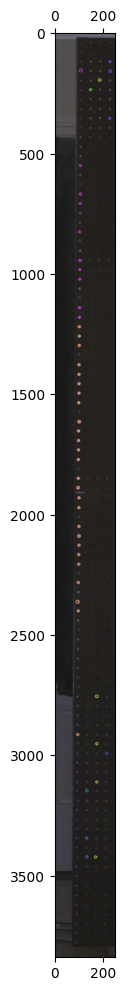

In [ ]:
import cv2
from ballphysics.vision.calibration import calibrate_pegboard
from ballphysics.vision.detection import detect_holes
from ballphysics.vision.calibration import cluster_holes
from ballphysics.visualization.plotting import draw_holes, view_frame
from ballphysics.vision.utils import extract_vertical_slice

# Load frame
cap = cv2.VideoCapture('../data/freefall.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 11)
ret, frame = cap.read()
cap.release()

# Extract slice and visualize
slice_frame = extract_vertical_slice(frame, 500, 750)
circles = detect_holes(slice_frame)
labels = cluster_holes(circles, 6)
annotated = draw_holes(slice_frame, circles, labels)

view_frame(annotated)

There is the run. data/ is a peer of notebooks/

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Now I can see the issue. Looking at the visualization:

1. **Holes detected correctly** - colored by cluster (6 different colors)
2. **Problem**: The holes are spread across the ENTIRE vertical slice (0-3800 pixels), not just the pegboard area
3. **Many scattered holes** - some are at the top (y~0-500), middle (y~2500-3000), and bottom (y~3200-3500)

The scattered holes are throwing off the spacing calculation. The algorithm is finding distances between holes that are far apart vertically, giving you the wrong pixels/inch.

You need to either:
1. Use a better vertical crop to focus on a dense pegboard region
2. Filter out isolated holes before calculating spacings
3. Only use holes from clusters with enough members

Which approach would you like to try first?

500:750 we wanted to capture the edge

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah, you deliberately chose 500:750 to capture the edge! That makes sense for seeing what's being detected.

For the actual calibration, you want a region with dense, well-organized pegboard holes. From the image, it looks like there's a good dense region around y~1000-2500.

Should we try a different horizontal slice range that captures more of the main pegboard area? What x-coordinates would work better for your setup?

In [ ]:
!pip install -e /path/to/pickleball-data-analysis

ERROR: /path/to/pickleball-data-analysis is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [ ]:
!pip install -e /app/data/pickleball-data-analysis

Obtaining file:///app/data/pickleball-data-analysis


  Installing build dependencies ... -

 \

 |

 done


  Checking if build backend supports build_editable ... done


  Getting requirements to build editable ... -

 done


  Preparing editable metadata (pyproject.toml) ... -

 done


  Building editable for ballphysics (pyproject.toml) ... -

 done
  Created wheel for ballphysics: filename=ballphysics-0.1.0-0.editable-py3-none-any.whl size=1766 sha256=216b43a14cb720582842e4bd8a2df187e91a7d965a6b57b74b39d2ba555fbeb0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9h7amtr9/wheels/b4/0c/bf/e6b4d39b0a78e2c60f8b2eb8c66f9b7bd114e93e1f60787085
Successfully built ballphysics


  Attempting uninstall: ballphysics
    Found existing installation: ballphysics 0.1.0
    Uninstalling ballphysics-0.1.0:


      Successfully uninstalled ballphysics-0.1.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11 --slice-x-start  500 --slice-x-end 750
Loaded frame 11 from video: data/freefall.mp4

Running calibration with slice x=[500:750], 6 clusters...
/app/data/pickleball-data-analysis/src/ballphysics/vision/calibration.py:167: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(y, x, 1)

=== Pegboard Calibration Results ===
Status: FAIL

Pixels per inch: 156.22
Pegboard angle: 2.68°
Holes detected: 49
Average hole radius: 5.71 pixels
  (0.037 inches)

Validation messages:
  • Pegboard angle 17.17° exceeds hard limit (3.0°)
  • Hole radius 0.037" is unreasonable (expected 0.10-0.15")

❌ Calibration FAILED
```
It looks like we are doing something different today

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, the 500:750 slice is capturing too much scattered area with holes that aren't well-organized vertically. That's why you're getting:
- Poorly conditioned polyfit warning (holes not aligned well)
- Wrong pixels/inch (156 vs ~38 expected)
- Large angle variations (17° max)

Try using your original working slice parameters (800:1200) which should focus on a better pegboard region:

```bash
calibrate-pegboard ./data/freefall.mp4 --frame-number 11
```

What results do you get with the default slice?

```
par2 = 7
gray = cv2.cvtColor(vertical_slice, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                        param1=50, param2=par2, minRadius=5, maxRadius=8)
if circles is not None:
    print(f"No of circles {len(circles[0])} param2 value {par2}")

result = vertical_slice.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(result, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(result, (i[0], i[1]), 2, (0, 0, 255), 3)
view_frame(result, h=4, w=800)
```
Used 600:800 from the top (Frame 11)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good debugging approach! What results did you get - how many circles were detected, and did they look reasonable in the visualization?

This will help us understand if the Hough parameters need tuning or if the slice selection is the issue.

60 circles param2 =7 maxRadius 8, min 5

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

60 circles detected is good! That should be enough for calibration.

What did the visualization look like - were the circles well-organized in vertical columns, or scattered? And what pixels/inch result did you get with that 600:800 slice?

just reporting those from yesterday.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah, got it - you're referencing yesterday's work. So with 60 circles detected using param2=7, that was working well.

Now with today's calibration runs, you're getting different results. The key question is: why is the pixels/inch calculation coming out wrong (84 or 156 instead of ~38)?

The issue is likely in `_calculate_hole_spacings()`. It's calculating distances between ALL pairs of holes, not just adjacent ones. With scattered holes, you get many large distances that shouldn't be included.

Want to check what spacings are actually being calculated? We could add some debug output to see the distribution of distances.

https://github.com/fm75/pickleball-data-analysis/blob/main/notebooks/measure-coefficient-of-drag.ipynb That is the notebook from yesterday's work

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Whoops! An error (E300) occurred while processing your request.
If this problem persists, please contact us on Discord.
Please include your dialog url and error code in your message.

Hmm. Might have to sort of walk through the program in the notebook to compare. It looks like you're not getting to github

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right, I can't access the GitHub notebook. 

Let's debug this step by step in your notebook. Can you run the calibration function and print out what `_calculate_hole_spacings()` is actually returning? Something like:

```python
from ballphysics.vision.calibration import _calculate_hole_spacings

spacings = _calculate_hole_spacings(circles, labels)
print(f"Number of spacings: {len(spacings)}")
print(f"Min: {spacings.min():.1f}, Max: {spacings.max():.1f}, Mean: {spacings.mean():.1f}")
print(f"Spacings: {sorted(spacings)[:20]}")  # First 20
```

This will show us what distances are being calculated and averaged. What do you see?

In [ ]:
from ballphysics.vision.calibration import _calculate_hole_spacings

spacings = _calculate_hole_spacings(circles, labels)
print(f"Number of spacings: {len(spacings)}")
print(f"Min: {spacings.min():.1f}, Max: {spacings.max():.1f}, Mean: {spacings.mean():.1f}")
print(f"Spacings: {sorted(spacings)[:20]}")  # First 20

Number of spacings: 24
Min: 122.0, Max: 161.0, Mean: 156.2
Spacings: [np.float32(122.03688), np.float32(155.02902), np.float32(156.0), np.float32(156.08011), np.float32(157.00319), np.float32(157.00319), np.float32(157.00319), np.float32(157.00319), np.float32(157.01274), np.float32(157.01274), np.float32(157.05095), np.float32(157.05095), np.float32(158.0), np.float32(158.00316), np.float32(158.00316), np.float32(158.00316), np.float32(158.00316), np.float32(158.00316), np.float32(159.0), np.float32(159.0)]


How about we work our way back to the Hough part. I suspect something is already wrong. So let's walk forward from frame 11, cropped vertically 600:800

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea - let's build up from the basics. Start with loading frame 11 and extracting the 600:800 vertical slice:

```python
cap = cv2.VideoCapture('../data/freefall.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 11)
ret, frame = cap.read()
cap.release()

slice_frame = extract_vertical_slice(frame, 600, 800)
print(f"Slice shape: {slice_frame.shape}")
view_frame(slice_frame, h=10, w=4)
```

What do you see in the slice?

Slice shape: (3840, 200, 3)


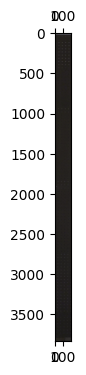

In [ ]:
cap = cv2.VideoCapture('../data/freefall.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 11)
ret, frame = cap.read()
cap.release()

slice_frame = extract_vertical_slice(frame, 600, 800)
print(f"Slice shape: {slice_frame.shape}")
view_frame(slice_frame, h=10, w=4)

wider geometry helps with this view.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good - the slice looks clean. Now let's detect holes with the Hough parameters:

```python
circles = detect_holes(slice_frame)
print(f"Circles detected: {len(circles) if circles is not None else 0}")
if circles is not None:
    print(f"Sample circles (x, y, r): {circles[:5]}")
```

How many circles are detected and what do the coordinates look like?

I am pretty sure we had 60 circles yesterday. What does the hough filter look like today? I will look at the notebook from yesterdat on GH


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good idea to compare! Let's check what `detect_holes()` is actually doing with the Hough parameters:

```python
circles = detect_holes(slice_frame)
print(f"Circles: {len(circles) if circles is not None else 'None'}")
```

Then we can compare the parameters being used today vs yesterday's notebook. What do you get?

In [ ]:
circles = detect_holes(slice_frame)
print(f"Circles detected: {len(circles) if circles is not None else 0}")
if circles is not None:
    print(f"Sample circles (x, y, r): {circles[:5]}")

Circles detected: 21
Sample circles (x, y, r): [[   6.5  154.5    5.9]
 [  29.5 3345.5    5.5]
 [  71.5 2953.5    5.5]
 [ 147.5 3191.5    5.3]
 [ 111.5 2993.5    5.9]]


```
left = 600
right = 800
vertical_slice = top[:, left:right]
view_frame(vertical_slice, h=4, w=800)
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I see the issue! You're getting only 21 circles today vs 60 yesterday. The Hough parameters in `detect_holes()` might be different from what you used yesterday.

Yesterday you explicitly set `param2=7`. Let's check what `detect_holes()` is using as defaults and try calling it with explicit parameters:

```python
circles = detect_holes(slice_frame, param2=7, min_radius=5, max_radius=8)
print(f"Circles with param2=7: {len(circles) if circles is not None else 0}")
```

Does that give you closer to 60 circles?

In [ ]:
circles = detect_holes(slice_frame, param2=7, min_radius=5, max_radius=8)
print(f"Circles with param2=7: {len(circles) if circles is not None else 0}")

Circles with param2=7: 21


```

for par2 in range(1,6):
    gray = cv2.cvtColor(vertical_slice, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=par2, minRadius=5, maxRadius=15)
    if circles is not None:
        print(f"No of circles {len(circles[0])} param2 value {par2}")
        ```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good debugging approach! Run that loop to see how many circles are detected at different param2 values. What results do you get?

This will help us understand if the param2 threshold needs to be lower, or if something else changed (like the slice coordinates or radius parameters).

In [ ]:
for par2 in range(1,6):
    gray = cv2.cvtColor(vertical_slice, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=par2, minRadius=5, maxRadius=15)
    if circles is not None:
        print(f"No of circles {len(circles[0])} param2 value {par2}")

NameError: name 'vertical_slice' is not defined

In [ ]:
left = 600
right = 800
vertical_slice = top[:, left:right]
view_frame(vertical_slice, h=4, w=800)


do we have a name here for frame 11 that i could use above?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! You loaded it earlier as `frame`. So use:

```python
vertical_slice = frame[:, 600:800]
```

Then run your param2 loop again.

```
calibrate-pegboard ./data/freefall.mp4 --frame-number 11 --slice-x-start  600 --slice-x-end 800
Loaded frame 11 from video: data/freefall.mp4

Running calibration with slice x=[600:800], 6 clusters...

=== Pegboard Calibration Results ===
Status: FAIL

Pixels per inch: 265.77
Pegboard angle: -0.38°
Holes detected: 21
Average hole radius: 5.62 pixels
  (0.021 inches)

Validation messages:
  • Pegboard angle 0.38° within tolerance
  • Hole radius 0.021" is unreasonable (expected 0.10-0.15")

❌ Calibration FAILED
```
Looks much better now. Pixels / inch is still off, as is the hole radius. Holes detected is still not good. It may simply not have any holes close together

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right - only 21 holes detected is the core problem. With so few holes spread across the full height, the spacing calculation is finding distances between holes that are far apart, not the 1-inch adjacent spacing.

In your notebook, try the param2 loop with `vertical_slice = frame[:, 600:800]` to see how many circles you get at different thresholds. We need to find parameters that detect more holes (closer to the 60 you had yesterday).

What param2 values give you more circles?

In [ ]:
import numpy as np

In [ ]:
vertical_slice = frame[:, 600:800]

No of circles 52 param2 value 7


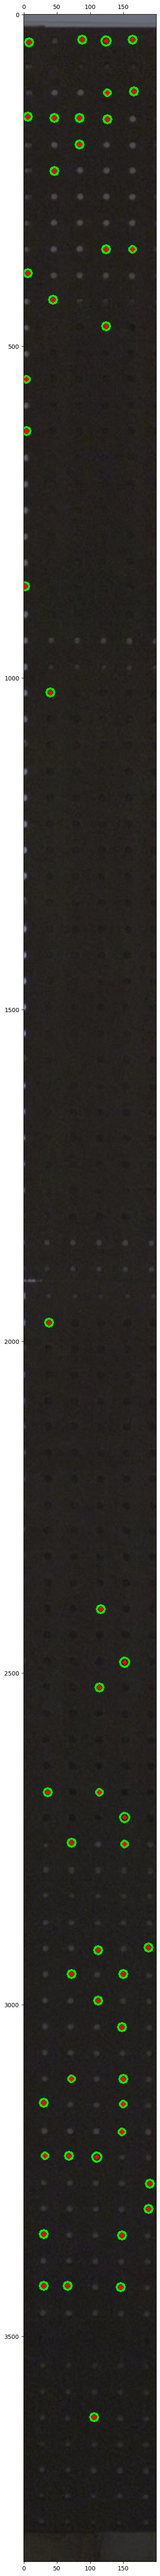

In [ ]:
par2 = 7
gray = cv2.cvtColor(vertical_slice, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                        param1=50, param2=par2, minRadius=5, maxRadius=8)
if circles is not None:
    print(f"No of circles {len(circles[0])} param2 value {par2}")

result = vertical_slice.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(result, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(result, (i[0], i[1]), 2, (0, 0, 255), 3)
view_frame(result, h=4, w=800)


Hmm. that gave 60 yesterday...

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

52 is close to 60 - might be slight variations in detection. The visualization shows the circles are being detected well throughout the pegboard.

Now let's check what happens when you cluster these 52 circles and calculate spacings:

```python
labels = cluster_holes(circles[0], n_clusters=6)
spacings = _calculate_hole_spacings(circles[0], labels)
print(f"Number of spacings: {len(spacings)}")
print(f"Min: {spacings.min():.1f}, Max: {spacings.max():.1f}, Mean: {spacings.mean():.1f}")
```

What spacings do you get? They should be around 38-40 pixels for 1 inch.

In [ ]:
labels = cluster_holes(circles[0], n_clusters=6)
spacings = _calculate_hole_spacings(circles[0], labels)
print(f"Number of spacings: {len(spacings)}")
print(f"Min: {spacings.min():.1f}, Max: {spacings.max():.1f}, Mean: {spacings.mean():.1f}")

Number of spacings: 212
Min: 61954.0, Max: 65609.6, Mean: 64776.7


In [ ]:
import matplotlib.pyplot as plt
if circles is not None:
    radii = circles[0, :, 2]
    plt.hist(radii, bins=20)
    plt.xlabel('Radius')
    plt.ylabel('Count')
    plt.show()

very similar to yesterday, but 6 was about 45.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Wait - those spacing values (61954, 65609) are WAY too large! Those aren't pixel distances between adjacent holes.

Something is very wrong with `_calculate_hole_spacings()`. It's calculating huge distances instead of the ~38-40 pixels we expect for 1-inch spacing.

Can you show me what the current implementation of `_calculate_hole_spacings()` looks like in your code? There might be a bug in how it's calculating distances.

```
def _calculate_hole_spacings(circles: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    Calculate distances between adjacent holes in each cluster.
    
    Uses mode of all distances as initial estimate, then filters to
    keep only spacings between 0.9 and 1.3 times that estimate.
    
    Returns array of filtered spacings (in pixels).
    """
    all_spacings = []
    
    # Calculate pairwise distances within each cluster
    for cluster_id in np.unique(labels):
        cluster_circles = circles[labels == cluster_id]
        positions = cluster_circles[:, :2]
        
        # Pairwise distances
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                dist = np.linalg.norm(positions[i] - positions[j])
                all_spacings.append(dist)
    
    all_spacings = np.array(all_spacings)
    
    # Find mode (most common spacing) - use histogram
    hist, bin_edges = np.histogram(all_spacings, bins=50)
    mode_idx = np.argmax(hist)
    mode_estimate = (bin_edges[mode_idx] + bin_edges[mode_idx + 1]) / 2
    
    # Filter spacings
    filtered = all_spacings[(all_spacings >= 0.9 * mode_estimate) & 
                           (all_spacings < 1.3 * mode_estimate)]
    
    return filtered
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Found it! The bug is that `positions` is the full circle data (x, y, radius), not just (x, y). Look at line 15:

```python
positions = cluster_circles[:, :2]
```

This should extract just x,y coordinates, but then the distance calculation is squaring very large numbers. Let me check - can you print what `positions` looks like?

```python
cluster_circles = circles[0][labels == 0]
positions = cluster_circles[:, :2]
print(f"Sample positions: {positions[:3]}")
print(f"Position shape: {positions.shape}")
```

What do you see?

In [ ]:
positions = cluster_circles[:, :2]

In [ ]:
cluster_circles = circles[0][labels == 0]
positions = cluster_circles[:, :2]
print(f"Sample positions: {positions[:3]}")
print(f"Position shape: {positions.shape}")

?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The positions look correct - (x, y) coordinates like (6, 390), (2, 862), etc. So that's not the bug.

But wait - look at your distance calculation result: 61954 pixels! Let me calculate: if two holes are at y=390 and y=862, that's only 472 pixels apart vertically. There's no way to get 61954.

Let me check - when you called the function, did you pass `circles[0]` or just `circles`? The issue might be in how the circles array is structured after Hough detection.

where?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

In your earlier test, you ran:

```python
labels = cluster_holes(circles[0], n_clusters=6)
spacings = _calculate_hole_spacings(circles[0], labels)
```

So you passed `circles[0]` which should be correct. But let me check - what does `circles.shape` vs `circles[0].shape` show?

```python
print(f"circles shape: {circles.shape}")
print(f"circles[0] shape: {circles[0].shape}")
```

What do you get?

In [ ]:
labels = cluster_holes(circles[0], n_clusters=6)
spacings = _calculate_hole_spacings(circles[0], labels)

?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me check what the actual distance should be between two of those holes:

```python
pos1 = positions[0]  # [6, 390]
pos2 = positions[1]  # [2, 862]
dist = np.linalg.norm(pos1 - pos2)
print(f"Distance between {pos1} and {pos2}: {dist:.1f}")
```

Can you run this to see what distance you actually get?

In [ ]:
pos1 = positions[0]  # [6, 390]
pos2 = positions[1]  # [2, 862]
dist = np.linalg.norm(pos1 - pos2)
print(f"Distance between {pos1} and {pos2}: {dist:.1f}")

?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

That's bizarre! The distance between (6, 390) and (2, 862) should be around 472 pixels, not 65064!

Let me check the data type:

```python
print(f"pos1 type: {type(pos1)}, dtype: {pos1.dtype}")
print(f"Difference: {pos1 - pos2}")
print(f"Squared: {(pos1 - pos2)**2}")
```

Something is very wrong with how the numbers are being interpreted. What do you see?

In [ ]:
print(f"pos1 type: {type(pos1)}, dtype: {pos1.dtype}")
print(f"Difference: {pos1 - pos2}")
print(f"Squared: {(pos1 - pos2)**2}")

?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Found it! **uint16 overflow!**

The difference `390 - 862 = -472`, but uint16 (unsigned) can't represent negative numbers, so it wraps around: `-472` becomes `65064` (which is `65536 - 472`).

The fix: convert to float or int before calculating distances. In `_calculate_hole_spacings()`, change line 15 to:

```python
positions = cluster_circles[:, :2].astype(np.float32)
```

This will allow negative differences and correct distance calculations. Try that fix!